# Lecture 2: Framing Prediction Problems & k-Nearest Neighbors

## Learning Objectives

By the end of this lecture, you will:
- **Understand** how to frame real-world problems as ML tasks with inputs (X) and outputs (y)
- **Apply** k-NN to make predictions and understand the role of the k parameter
- **Analyze** the impact of distance metrics and feature scaling on predictions
- **Explore** the curse of dimensionality and its implications
- **Design** fair and effective matching systems with domain-specific constraints
- **Evaluate** trade-offs between different similarity measures



## Today's Journey

We'll solve a real problem: **Finding compatible ML project teammates** using k-Nearest Neighbors

This isn't just a toy example - you'll actually use this to form your project teams!


# Part 1: The Problem - Finding Your ML Team

## Why Team Formation Matters

Good collaboration is crucial for ML projects. But how do we find compatible teammates?
- Similar interests? 
- Complementary skills?
- Compatible working styles?

Let's use ML to help!

### What we'll explore in our setup:
- Load real student survey data processed by NLP
- Examine the 8-dimensional feature space
- Understand how text responses became numbers

In [1]:
try:
    import plotly  # already installed
except ImportError:
    %pip install -q plotly --disable-pip-version-check
%pip install -q --disable-pip-version-check "matplotlib>=3.7" seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import IFrame, display, HTML
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

In [3]:
# Load our class data with proper structure
with open('project-matchmaker/student_data.json', 'r') as f:
    data = json.load(f)
    
# Extract components from the JSON structure    
students_list = data['students']
dimensions = data['dimensions']
dimension_descriptions = data['dimension_descriptions']
categorical_features = data['categorical_features']

# Convert to DataFrame for easier manipulation
students = pd.DataFrame(students_list)

# Display basic statistics
n_students = len(students)
n_dimensions = len(dimensions)
n_categorical = len(categorical_features)

In [4]:
from IPython.display import display
import pandas as pd

# Decide columns
numeric_cols = dimensions if 'dimensions' in locals() and len(dimensions) else [c for c in students.select_dtypes(include='number').columns]

# Handle categorical metadata (dict or list)
if isinstance(categorical_features, dict):
    cat_items = list(categorical_features.items())
    cat_cols = list(categorical_features.keys())
else:
    cat_items = [(c, {}) for c in categorical_features]
    cat_cols = list(categorical_features)

print(f"Total students surveyed: {len(students)}")
print(f"Numerical dimensions ({len(numeric_cols)}): {', '.join(numeric_cols)}")
print(f"Categorical features ({len(cat_cols)}): {', '.join(cat_cols)}")

# Pretty print categorical details
for key, meta in cat_items:
    name = meta.get('name', key)
    values = meta.get('values', None)
    if values is not None:
        print(f"  - {name} [{key}]: {len(values)} levels -> {', '.join(map(str, values))}")
    else:
        print(f"  - {name} [{key}]")

# Optional: sample original responses if you have that column
# original_text_col = 'original_response'
if 'original_text_col' in locals() and original_text_col in students.columns:
    print("Original responses (sample):")
    for i, txt in enumerate(students[original_text_col].dropna().astype(str).head(3), 1):
        print(f"  {i}. {txt[:200]}")

Total students surveyed: 10
Numerical dimensions (8): theory_implementation, research_industry, structured_exploratory, solo_collaborative, depth_breadth, plan_iterate, data_model, foundational_applied
Categorical features (6): team_status, main_interest, experience_level, problem_preference, collaboration_style, has_project_idea
  - Team Formation Status [team_status]: 4 levels -> solo, seeking_small, seeking_medium, seeking_large
  - Primary Interest Area [main_interest]: 7 levels -> nlp, computer_vision, healthcare, robotics, energy, cybersecurity, general
  - Experience Level [experience_level]: 3 levels -> beginner, intermediate, advanced
  - Problem Type Preference [problem_preference]: 3 levels -> structured, exploratory, both
  - Collaboration Style [collaboration_style]: 3 levels -> meetings, divided, flexible
  - Has Specific Project Idea [has_project_idea]: 2 levels -> True, False


### **Data Overview:**
- **Total students surveyed:** Check how many responses we have
- **Numerical dimensions:** 8 features extracted from text responses
- **Categorical features:** Team status, interests, experience level
- **Original responses:** Preserved for transparency and validation

## Let's See It In Action First!

Before diving into the theory, let's experience k-NN working on YOUR data.

### **Interactive Demo Features:**
- Real-time k-NN visualization with your classmates' data
- Adjustable k parameter to see immediate effects
- Multiple dimension pairs to explore different perspectives
- Color coding by categorical features

In [5]:
import socket, subprocess, time, webbrowser
from pathlib import Path
from IPython.display import HTML, display

# Relative to the notebook location
REL_DIR = Path("project-matchmaker")   # or Path("project-matchmaker") if notebook is inside "Lecture 2 KNN/"
assert REL_DIR.exists(), f"Folder not found: {REL_DIR.resolve()}"

# Pick entry file
entry = "index-new.html" if (REL_DIR / "index-new.html").exists() else "index.html"
assert (REL_DIR / entry).exists(), f"No entry HTML found at {REL_DIR/entry}"

# Get a free port
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind(("localhost", 0))
    PORT = s.getsockname()[1]

# Start server for that directory
subprocess.Popen(
    ["python", "-m", "http.server", str(PORT), "--directory", str(REL_DIR)],
    stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
)
time.sleep(1.0)

url = f"http://localhost:{PORT}/{entry}"
display(HTML(f'<a href="{url}" target="_blank">Open Interactive Demo in Browser</a>'))
# Optional: auto-open default browser
# webbrowser.open(url)
print("Serving:", REL_DIR.resolve())
print("URL:", url)

Serving: /Users/ming/Dropbox/learn-ml-by-building/Lecture 2 KNN/project-matchmaker
URL: http://localhost:51189/index-new.html



### **Key Observations from the Demo:**

After experimenting with the demo, you should notice:
- **Proximity = Similarity**: Students closer in the visualization have more similar preferences
- **K's Impact**: Smaller K → more specific matches, larger K → more general consensus
- **Dimension Dependency**: Your "neighbors" completely change based on which 2 of 8 dimensions you visualize
- **Clustering Patterns**: Natural groups form based on interests and working styles


# Part 2: Understanding the Data

## From Surveys to Numbers

Your text responses were transformed into numerical features using NLP. Let's peek under the hood:

### **What this code reveals:**
- How qualitative survey responses become quantitative features
- The meaning of each dimension on a -1 to +1 scale
- Visual representation of where a student falls on each spectrum

In [6]:
import matplotlib.pyplot as plt
import textwrap

def visualize_student_profile(student_idx=0,
                              base_font=12,        # overall text
                              title_font=13,       # per-row title
                              anchor_font=11,      # left/right labels
                              right_text_font=11,  # right panel text
                              suptitle_font=16,    # top title
                              marker_size=9,
                              bar_height=0.36,
                              wrap_width=64,
                              dpi=150):
    sample = students.iloc[student_idx]
    n_dims = len(dimensions)

    fig = plt.figure(figsize=(13, 1.25 * n_dims + 2), dpi=dpi)
    gs = fig.add_gridspec(nrows=n_dims, ncols=2, width_ratios=[2.4, 1.8],
                          wspace=0.38, hspace=0.62)

    for i, dim in enumerate(dimensions):
        ax = fig.add_subplot(gs[i, 0])
        value = float(sample[dim])

        ax.barh(0, 2, left=-1, height=bar_height, color='lightgray', alpha=0.3)
        color = 'green' if value > 0 else 'red'
        ax.barh(0, value, height=bar_height, color=color, alpha=0.85)
        ax.plot(value, 0, 'o', color='black', markersize=marker_size)

        ax.set_xlim(-1, 1)
        ax.set_ylim(-0.5, 0.5)
        ax.set_yticks([])
        ax.axvline(0, color='black', linestyle='--', alpha=0.3)
        ax.tick_params(labelsize=base_font)

        desc = dimension_descriptions[dim]
        if '→' in desc:
            left_label, right_label = desc.split('→')
        elif '->' in desc:
            left_label, right_label = desc.split('->')
        else:
            left_label, right_label = desc, ''
        left_label = left_label.replace('←', '').strip()
        right_label = right_label.strip()

        ax.text(-0.95, -0.38, left_label, fontsize=anchor_font, ha='left')
        ax.text(0.95, -0.38, right_label, fontsize=anchor_font, ha='right')
        ax.set_title(f"{dim.replace('_', ' ').title()}: {value:+.2f}",
                     fontsize=title_font, loc='left')

        for side in ('top', 'right', 'bottom'):
            ax.spines[side].set_visible(False)

    ax_text = fig.add_subplot(gs[:, 1])
    ax_text.axis('off')

    lines = []
    lines.append(f"{sample.get('name','(unknown)')}  •  {sample.get('email','')}")
    lines.append(f"Interest: {sample.get('main_interest','')}")
    contact = sample.get('contact', '')
    if contact:
        lines.append(f"Contact: {contact}")
    lines.append("")
    lines.append("Original responses:")

    orig = sample.get('original_responses', {})
    ordered_keys = [
        'application_area', 'team_needed', 'project_approach',
        'experience', 'problem_type', 'project_ideas', 'collaboration_style'
    ]
    label_map = {
        'application_area': 'Application Area',
        'team_needed': 'Team Needed',
        'project_approach': 'Project Approach',
        'experience': 'Experience',
        'problem_type': 'Problem Type',
        'project_ideas': 'Project Ideas',
        'collaboration_style': 'Collaboration Style',
    }
    for k in ordered_keys:
        if isinstance(orig, dict) and k in orig:
            lines.append(f"{label_map.get(k, k.replace('_',' ').title())}:")
            for wrapped in textwrap.wrap(str(orig[k]), width=wrap_width):
                lines.append(f"  {wrapped}")
            lines.append("")

    ax_text.text(0, 1, "\n".join(lines), va='top', ha='left', fontsize=right_text_font)

    fig.suptitle(f"Profile: {sample.get('name','(unknown)')} — {sample.get('main_interest','')}",
                 fontsize=suptitle_font, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

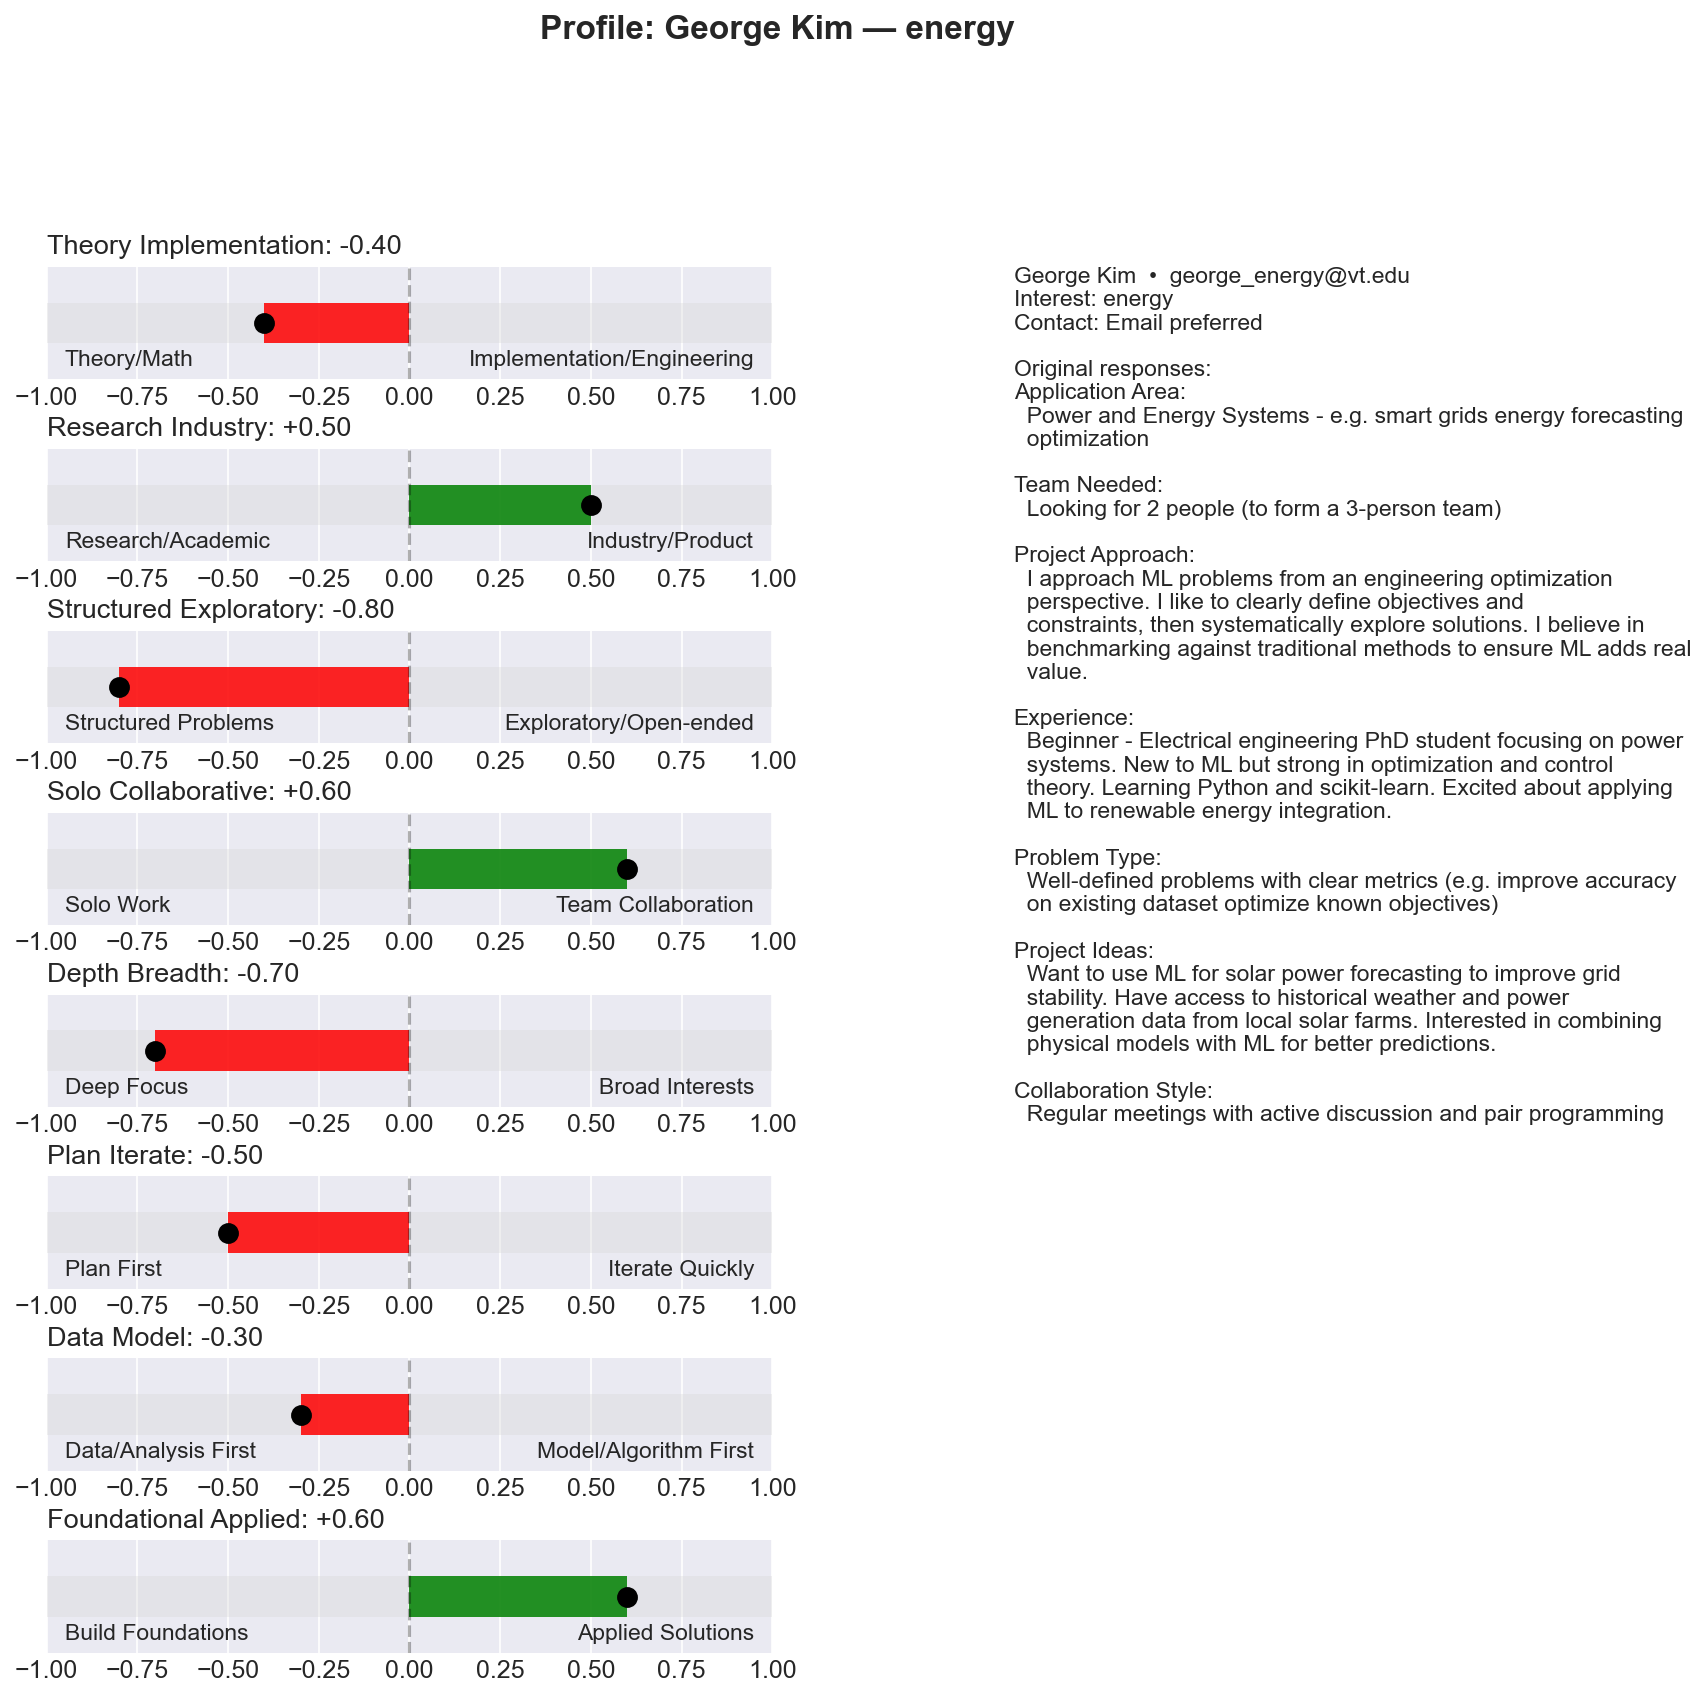

In [7]:
visualize_student_profile(np.random.randint(0, len(students)))

### 💡 **Profile Interpretation:**
- **Negative values** (left side): Theory, research, structured, solo work preferences
- **Positive values** (right side): Implementation, industry, exploratory, collaborative preferences  
- **Near zero**: Balanced or neutral on that dimension
- **Extreme values** (±0.8+): Strong preferences that heavily influence matching


## The Feature Space

### **Distribution Analysis Goals:**
- Understand the diversity of student preferences
- Identify potential clustering or gaps
- Check for feature scaling issues
- Detect any extraction biases

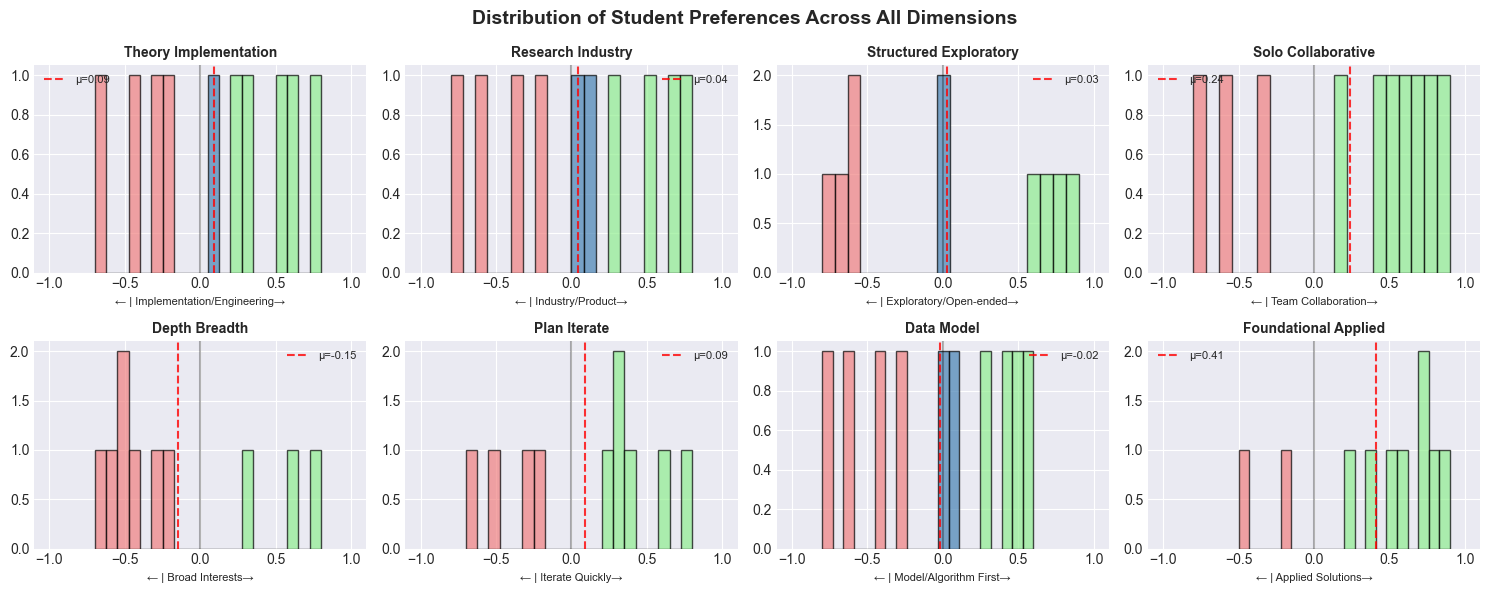

In [8]:
def analyze_feature_distributions():
    """
    Analyze and visualize the distribution of all numerical features
    """
    # Create figure with subplots for each dimension
    fig, axes = plt.subplots(2, 4, figsize=(15, 6))
    axes = axes.flatten()
    
    # Store statistics for later analysis
    feature_stats = {}
    
    for idx, dim in enumerate(dimensions):
        ax = axes[idx]
        values = students[dim].values
        
        # Calculate statistics
        feature_stats[dim] = {
            'mean': values.mean(),
            'std': values.std(),
            'min': values.min(),
            'max': values.max(),
            'skew': ((values - values.mean())**3).mean() / values.std()**3
        }
        
        # Plot distribution
        n, bins, patches = ax.hist(values, bins=20, alpha=0.7, 
                                   color='steelblue', edgecolor='black')
        
        # Color bars by position (red for negative, green for positive)
        for i, patch in enumerate(patches):
            if bins[i] < -0.1:
                patch.set_facecolor('lightcoral')
            elif bins[i] > 0.1:
                patch.set_facecolor('lightgreen')
        
        # Add mean line
        ax.axvline(values.mean(), color='red', linestyle='--', 
                  alpha=0.8, label=f'μ={values.mean():.2f}')
        ax.axvline(0, color='black', linestyle='-', alpha=0.3)
        
        # Labels and formatting
        description = dimension_descriptions[dim]
        ax.set_xlabel(f"←{description.split('→')[0].split('←')[-1].strip()} | "
                     f"{description.split('→')[1].strip()}→", fontsize=8)
        ax.set_title(dim.replace('_', ' ').title(), fontsize=10, fontweight='bold')
        ax.set_xlim(-1.1, 1.1)
        ax.legend(fontsize=8)
    
    plt.suptitle("Distribution of Student Preferences Across All Dimensions", 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return feature_stats

# Analyze distributions
feature_stats = analyze_feature_distributions()

### **Distribution Insights:**
- **Balanced dimensions**: Mean near 0 indicates good NLP extraction
- **Skewed dimensions**: May indicate biases in survey questions or extraction
- **Bimodal patterns**: Suggest natural groupings in the class
- **Range coverage**: Full use of [-1, 1] indicates good feature scaling


# Part 3: The k-NN Algorithm

## The Beautiful Simplicity of k-NN

### 🎯 **Core k-NN Principle:**
> "You are similar to your neighbors"

**No training phase needed!** k-NN is a "lazy learner" that:
1. Stores all training data
2. Makes predictions based on similarity at query time
3. Uses local patterns rather than global models

In [9]:
def knn_from_scratch(query_point, data_points, dimensions_to_use, k=3):
    """
    Implement k-NN from scratch to understand the algorithm
    
    Parameters:
    -----------
    query_point : array-like
        The point we want to find neighbors for
    data_points : DataFrame
        All available data points
    dimensions_to_use : list
        Which dimensions to use for distance calculation
    k : int
        Number of neighbors to find
    
    Returns:
    --------
    list of tuples: (index, distance, student_data)
    """
    distances = []
    
    # Step 1: Calculate distance to every other point
    for idx, point in data_points.iterrows():
        # Extract features for distance calculation
        point_features = point[dimensions_to_use].values
        
        # Euclidean distance calculation
        # d = sqrt(sum((x_i - y_i)^2))
        squared_diffs = (query_point - point_features) ** 2
        euclidean_dist = np.sqrt(squared_diffs.sum())
        
        # Store index, distance, and full student data
        distances.append((idx, euclidean_dist, point))
    
    # Step 2: Sort by distance (ascending - nearest first)
    distances.sort(key=lambda x: x[1])
    
    # Step 3: Return k nearest neighbors
    return distances[:k]



In [10]:
import pandas as pd

# Demonstrate with actual student data
# Let's find neighbors using just 2 dimensions for visualization
dims_to_use = ['theory_implementation', 'research_industry']

# Create a query point (implementation-focused, research-oriented)
query = np.array([0.5, -0.3])

# Find K nearest neighbors
neighbors = knn_from_scratch(query, students, dims_to_use, k=5)

# Pretty print k-NN results
cols = ['rank', 'idx', 'name', 'email', 'main_interest', 'distance'] + dims_to_use
rows = []
for r, (idx, dist, stu) in enumerate(neighbors, 1):
    rows.append([
        r,
        idx,
        stu.get('name', ''),
        stu.get('email', ''),
        stu.get('main_interest', ''),
        round(float(dist), 3),
        *[round(float(stu[d]), 3) for d in dims_to_use]
    ])

res_df = pd.DataFrame(rows, columns=cols)
print(f"k-NN results (k={len(neighbors)}, dims={dims_to_use}):")
display(res_df)

k-NN results (k=5, dims=['theory_implementation', 'research_industry']):


,rank,idx,name,email,main_interest,distance,theory_implementation,research_industry
0,1,0,Alice Johnson,alice123@vt.edu,nlp,0.224,0.3,-0.4
1,2,5,Fiona Williams,fiona_nlp@vt.edu,nlp,0.400,0.5,0.1
2,3,8,Ivan Rodriguez,ivan_general@vt.edu,general,0.424,0.2,0.0
3,4,7,Hannah Lee,hannah_cv@vt.edu,computer_vision,0.640,0.1,-0.8
4,5,3,Diana Patel,diana_data@vt.edu,healthcare,0.762,-0.2,-0.6


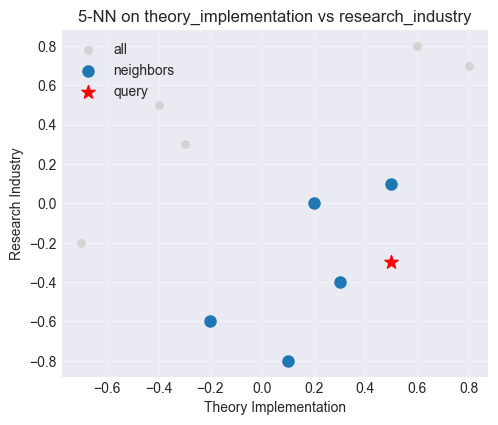

In [11]:
# 2D scatter (only if dims_to_use has length 2)
if len(dims_to_use) == 2:
    import matplotlib.pyplot as plt

    x, y = dims_to_use
    n_idx = [i for i, _, _ in neighbors]

    plt.figure(figsize=(5.5, 4.5))
    plt.scatter(students[x], students[y], s=28, c='lightgray', label='all')
    plt.scatter(students.loc[n_idx, x], students.loc[n_idx, y], s=64, c='tab:blue', label='neighbors')
    plt.scatter(query[0], query[1], s=100, c='red', marker='*', label='query')

    plt.xlabel(x.replace('_', ' ').title())
    plt.ylabel(y.replace('_', ' ').title())
    plt.title(f"{len(neighbors)}-NN on {x} vs {y}")
    plt.grid(alpha=0.25)
    plt.legend()
    plt.show()


### **Algorithm Analysis:**
- **Time Complexity**: O(n·d) for each query (n points, d dimensions)
- **Space Complexity**: O(n·d) to store all data
- **No Training Time**: O(1) - just store the data!
- **Query Time**: Linear in dataset size (can be slow for large datasets)


## Visualizing k-NN Decision Process

### **Visualization Goals:**
- Show how decision boundaries change with K
- Illustrate the bias-variance tradeoff
- Demonstrate overfitting (K=1) vs underfitting (large K)

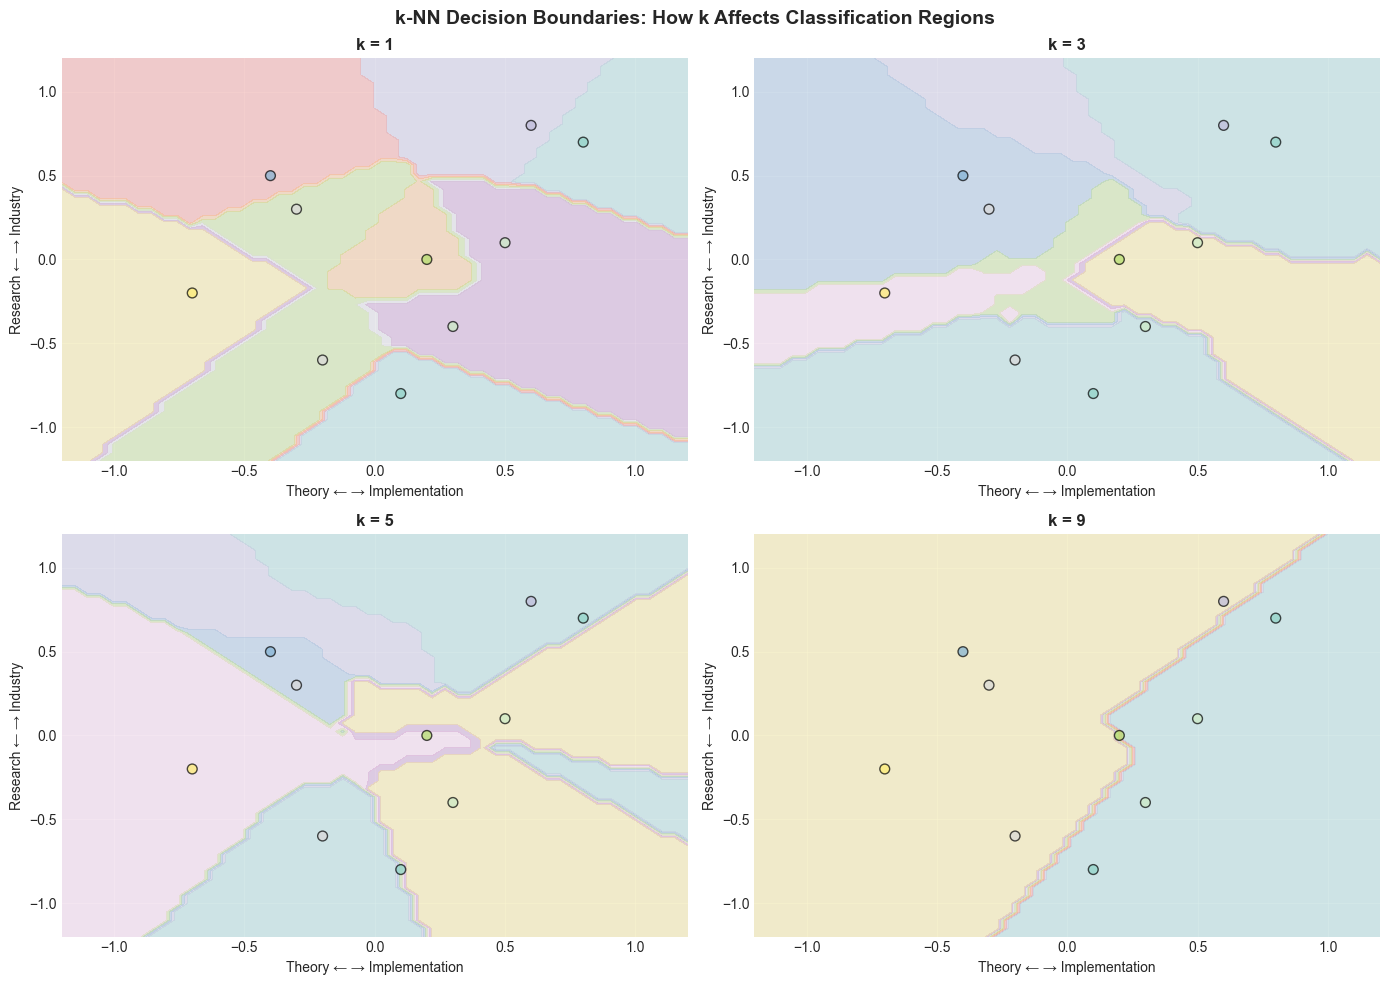

In [12]:
def visualize_knn_decision_boundaries(k_values=[1, 3, 5, 9]):
    """
    Create decision boundary visualizations for different k values
    
    This shows how the algorithm partitions the feature space
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # Use two dimensions for visualization
    x_dim = 'theory_implementation'
    y_dim = 'research_industry'
    
    # Create mesh grid for decision boundary
    x_min, x_max = -1.2, 1.2
    y_min, y_max = -1.2, 1.2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                        np.linspace(y_min, y_max, 50))
    
    # Prepare data for sklearn KNN
    X = students[[x_dim, y_dim]].values
    
    # Use main_interest as the classification target
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(students['main_interest'])
    
    for idx, k in enumerate(k_values):
        ax = axes[idx]
        
        # Train k-NN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X, y)
        
        # Predict for each point in mesh
        Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundaries
        ax.contourf(xx, yy, Z, alpha=0.3, cmap='Set3')
        
        # Plot actual data points
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set3', 
                           edgecolor='black', s=50, alpha=0.7)
        
        # Formatting
        ax.set_xlabel('Theory ← → Implementation')
        ax.set_ylabel('Research ← → Industry')
        ax.set_title(f'k = {k}', fontsize=12, fontweight='bold')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('k-NN Decision Boundaries: How k Affects Classification Regions', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize decision boundaries
visualize_knn_decision_boundaries()

### **Key Observations:**
- **K=1**: Highly complex boundaries, memorizes training data (overfitting)
- **K=3-5**: Balanced complexity, good generalization
- **K=9+**: Smooth boundaries, may miss local patterns (underfitting)
- **Irregular shapes**: k-NN can model non-linear decision boundaries naturally

# Part 4: The Curse of Dimensionality

## When More Features Hurt Performance

### **The Paradox:**
- More features should mean better discrimination, right?
- **Wrong!** In high dimensions, all points become equally distant
- This phenomenon breaks k-NN's fundamental assumption

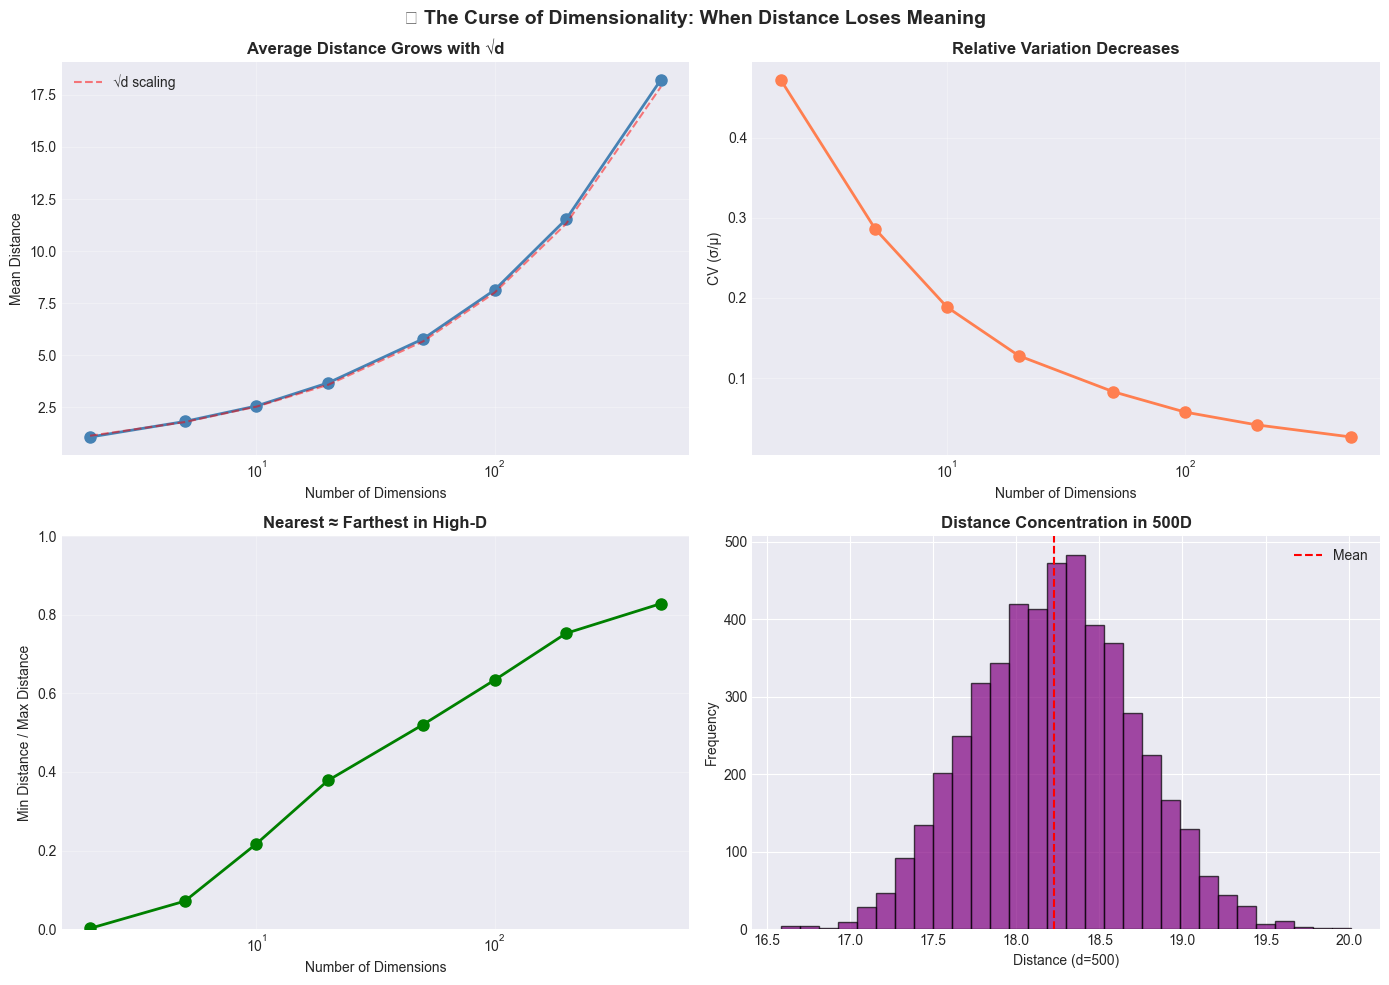

d=  2 | mean=1.069 | CV=0.472 | min/max=0.002
d=  5 | mean=1.817 | CV=0.286 | min/max=0.071
d= 10 | mean=2.561 | CV=0.189 | min/max=0.217
d= 20 | mean=3.670 | CV=0.128 | min/max=0.379
d= 50 | mean=5.776 | CV=0.083 | min/max=0.520
d=100 | mean=8.127 | CV=0.058 | min/max=0.634
d=200 | mean=11.532 | CV=0.042 | min/max=0.753
d=500 | mean=18.228 | CV=0.026 | min/max=0.828


In [13]:
from sklearn.metrics.pairwise import euclidean_distances
def demonstrate_curse_of_dimensionality():
    """
    Empirically demonstrate how distances lose meaning in high dimensions
    """
    # Test different dimensionalities
    dimensions_range = [2, 5, 10, 20, 50, 100, 200, 500]
    
    # Storage for results
    results = {
        'dims': dimensions_range,
        'mean_dist': [],
        'std_dist': [],
        'cv': [],  # Coefficient of variation
        'min_max_ratio': []
    }
    
    for d in dimensions_range:
        # Generate random data in d dimensions
        # 100 points uniformly distributed in unit hypercube
        np.random.seed(42)
        points = np.random.uniform(-1, 1, size=(100, d))
        
        # Calculate all pairwise distances
        distances = euclidean_distances(points)
        
        # Extract upper triangle (unique pairs only)
        upper_tri_indices = np.triu_indices(100, k=1)
        pairwise_distances = distances[upper_tri_indices]
        
        # Calculate statistics
        mean_d = pairwise_distances.mean()
        std_d = pairwise_distances.std()
        
        results['mean_dist'].append(mean_d)
        results['std_dist'].append(std_d)
        results['cv'].append(std_d / mean_d)  # Relative variability
        results['min_max_ratio'].append(
            pairwise_distances.min() / pairwise_distances.max()
        )
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Mean distance growth
    axes[0, 0].plot(results['dims'], results['mean_dist'], 
                    'o-', color='steelblue', linewidth=2, markersize=8)
    axes[0, 0].plot(results['dims'], np.sqrt(results['dims']) * 0.8, 
                    '--', color='red', alpha=0.5, label='√d scaling')
    axes[0, 0].set_xlabel('Number of Dimensions')
    axes[0, 0].set_ylabel('Mean Distance')
    axes[0, 0].set_title('Average Distance Grows with √d', fontweight='bold')
    axes[0, 0].set_xscale('log')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Coefficient of variation
    axes[0, 1].plot(results['dims'], results['cv'], 
                    'o-', color='coral', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Number of Dimensions')
    axes[0, 1].set_ylabel('CV (σ/μ)')
    axes[0, 1].set_title('Relative Variation Decreases', fontweight='bold')
    axes[0, 1].set_xscale('log')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Min/Max ratio
    axes[1, 0].plot(results['dims'], results['min_max_ratio'], 
                    'o-', color='green', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Number of Dimensions')
    axes[1, 0].set_ylabel('Min Distance / Max Distance')
    axes[1, 0].set_title('Nearest ≈ Farthest in High-D', fontweight='bold')
    axes[1, 0].set_xscale('log')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Distance concentration
    axes[1, 1].hist(pairwise_distances, bins=30, alpha=0.7, 
                    color='purple', edgecolor='black')
#     axes[1, 1].set_xlabel(f'Distance (d={dimensions_range[-1]})')
    axes[1, 1].set_xlabel(f"Distance (d={results['dims'][-1]})")
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distance Concentration in 500D', fontweight='bold')
    axes[1, 1].axvline(pairwise_distances.mean(), color='red', 
                       linestyle='--', label='Mean')
    axes[1, 1].legend()
    
    plt.suptitle('🔮 The Curse of Dimensionality: When Distance Loses Meaning', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    for d, mean, cv, mm in zip(results['dims'], results['mean_dist'], results['cv'], results['min_max_ratio']):
        print(f"d={d:>3} | mean={mean:.3f} | CV={cv:.3f} | min/max={mm:.3f}")
    
    return results

# Demonstrate the curse
curse_results = demonstrate_curse_of_dimensionality()

### **Critical Insights:**
- **Distance Growth**: Mean distance ∝ √d (square root of dimensions)
- **Variance Collapse**: Relative variation → 0 as d increases
- **Discrimination Loss**: min_dist/max_dist → 1 (all points equidistant!)
- **k-NN Breakdown**: When all points are equally far, k-NN becomes random

## Impact on Our Student Matching

### **Real-World Application:**
Let's see how dimensionality affects our actual student matching system

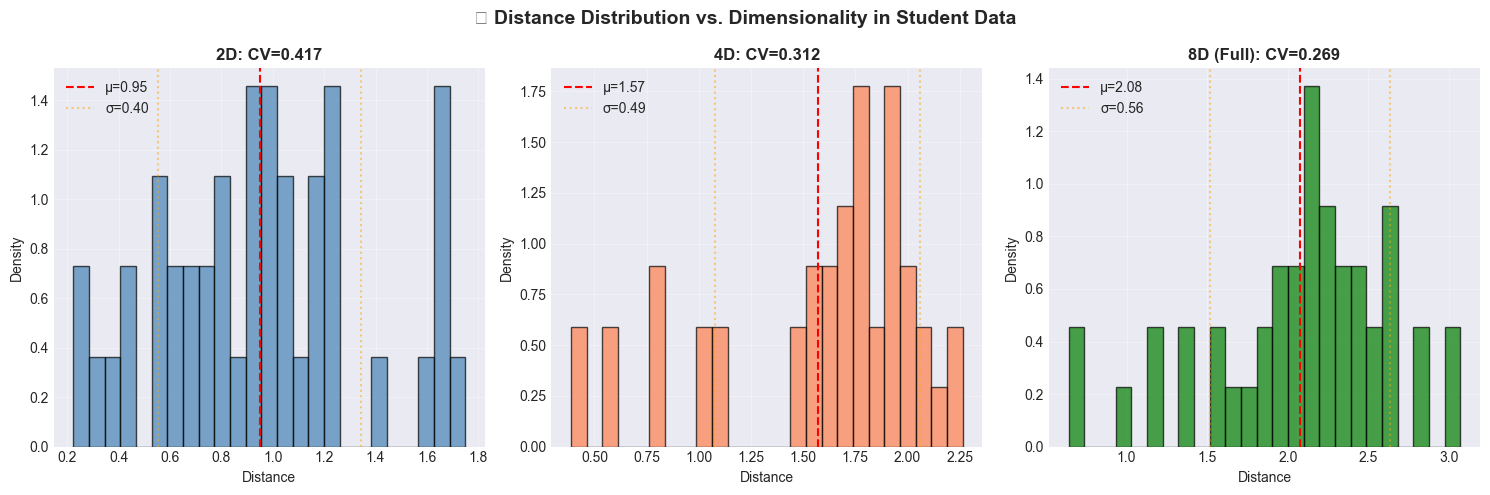

In [14]:
def analyze_student_distance_distribution():
    """
    Compare distance distributions using different numbers of features
    """
    # Define feature subsets of increasing size
    feature_sets = {
        '2D': dimensions[:2],
        '4D': dimensions[:4], 
        '8D (Full)': dimensions
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Store statistics for comparison
    stats_comparison = []
    
    for idx, (name, features) in enumerate(feature_sets.items()):
        ax = axes[idx]
        
        # Calculate pairwise distances
        X = students[features].values
        distances = euclidean_distances(X)
        
        # Get upper triangle (unique pairs)
        upper_tri = distances[np.triu_indices(len(students), k=1)]
        
        # Plot distribution
        n, bins, patches = ax.hist(upper_tri, bins=25, alpha=0.7, 
                                   color=['steelblue', 'coral', 'green'][idx],
                                   edgecolor='black', density=True)
        
        # Add statistics
        mean_dist = upper_tri.mean()
        std_dist = upper_tri.std()
        cv = std_dist / mean_dist
        
        ax.axvline(mean_dist, color='red', linestyle='--', 
                  label=f'μ={mean_dist:.2f}')
        ax.axvline(mean_dist - std_dist, color='orange', linestyle=':', 
                  alpha=0.5)
        ax.axvline(mean_dist + std_dist, color='orange', linestyle=':', 
                  alpha=0.5, label=f'σ={std_dist:.2f}')
        
        # Labels
        ax.set_xlabel('Distance')
        ax.set_ylabel('Density')
        ax.set_title(f'{name}: CV={cv:.3f}', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Store stats
        stats_comparison.append({
            'dimensions': name,
            'n_features': len(features),
            'mean': mean_dist,
            'std': std_dist,
            'cv': cv,
            'min': upper_tri.min(),
            'max': upper_tri.max(),
            'range_ratio': upper_tri.min() / upper_tri.max()
        })
    
    plt.suptitle('📐 Distance Distribution vs. Dimensionality in Student Data', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(stats_comparison)

# Analyze our actual data
distance_stats = analyze_student_distance_distribution()

### 💡 **Practical Implications:**
- **2D view**: High discrimination, but missing 75% of information
- **4D view**: Balanced - reasonable discrimination with key features
- **8D (full)**: Uses all information but suffers from curse effects
- **Solution**: Feature selection or dimensionality reduction may improve matching!

# Part 5: Distance Metrics - The Heart of K-NN

## Different Ways to Measure "Nearness"

### **Key Concept:**
In K-NN, the distance metric IS the model! Different metrics find different neighbors.

###  **Common Distance Metrics:**
- **Euclidean**: Straight-line distance (most common)
- **Manhattan**: City-block distance (sum of absolute differences)
- **Cosine**: Angle between vectors (direction matters, not magnitude)
- **Chebyshev**: Maximum coordinate difference (chess king moves)

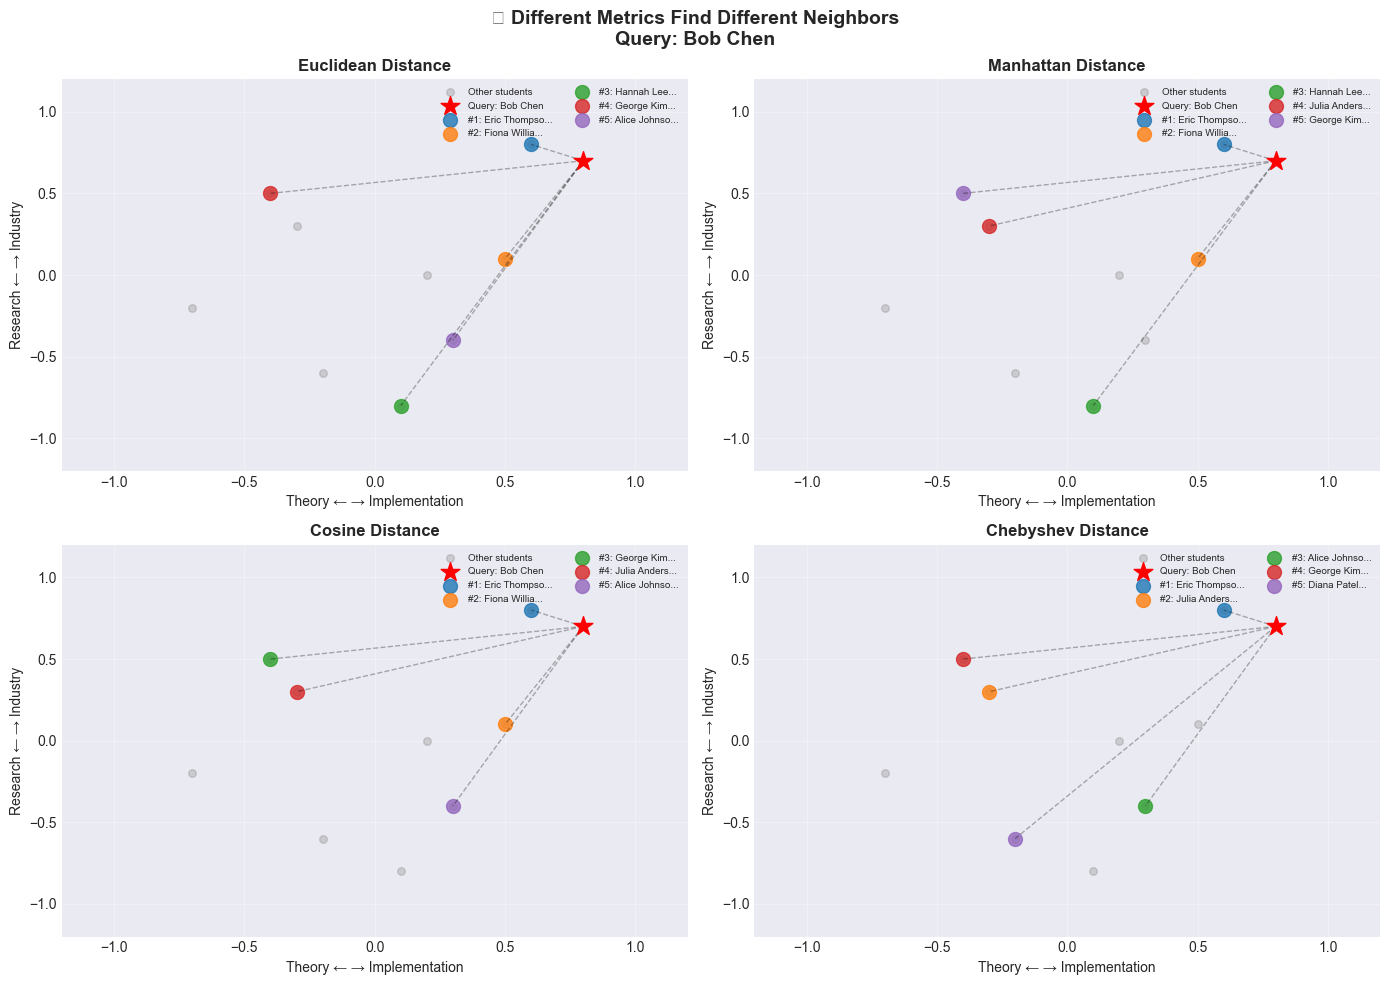

In [15]:
def compare_distance_metrics(query_idx = 0):
    """
    Compare how different metrics define "nearest neighbors"
    """
    # Select a query student
    query_student = students.iloc[query_idx]
    
    # Prepare feature matrix
    X = students[dimensions].values
    query_vector = query_student[dimensions].values.reshape(1, -1)
    
    # Calculate distances using different metrics
    from sklearn.metrics import pairwise_distances
    
    metrics_to_test = {
        'Euclidean': 'euclidean',
        'Manhattan': 'manhattan',
        'Cosine': 'cosine',
        'Chebyshev': 'chebyshev'
    }
    
    # Store results
    neighbor_comparison = {}
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (metric_name, metric) in enumerate(metrics_to_test.items()):
        ax = axes[idx]
        
        # Calculate distances
        distances = pairwise_distances(query_vector, X, metric=metric)[0]
        
        # Exclude self (set distance to infinity)
        distances[query_idx] = np.inf
        
        # Find top 5 neighbors
        top_5_indices = np.argsort(distances)[:5]
        neighbor_comparison[metric_name] = top_5_indices
        
        # Visualize in 2D projection
        # Plot all students
        ax.scatter(students['theory_implementation'], 
                  students['research_industry'],
                  alpha=0.3, s=30, color='gray', label='Other students')
        
        # Highlight query student
        ax.scatter(query_student['theory_implementation'],
                  query_student['research_industry'],
                  s=200, color='red', marker='*', 
                  label=f"Query: {query_student['name']}", zorder=5)
        
        # Highlight and connect neighbors
        for rank, neighbor_idx in enumerate(top_5_indices):
            neighbor = students.iloc[neighbor_idx]
            
            # Plot neighbor
            ax.scatter(neighbor['theory_implementation'],
                      neighbor['research_industry'],
                      s=100, marker='o', alpha=0.8,
                      label=f"#{rank+1}: {neighbor['name'][:12]}...")
            
            # Draw connection line
            ax.plot([query_student['theory_implementation'], 
                    neighbor['theory_implementation']],
                   [query_student['research_industry'], 
                    neighbor['research_industry']],
                   'k--', alpha=0.3, linewidth=1)
        
        # Formatting
        ax.set_xlabel('Theory ← → Implementation')
        ax.set_ylabel('Research ← → Industry')
        ax.set_title(f'{metric_name} Distance', fontsize=12, fontweight='bold')
        ax.legend(fontsize=7, loc='best', ncol=2)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
    
    plt.suptitle(f'🎯 Different Metrics Find Different Neighbors\nQuery: {query_student["name"]}', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return neighbor_comparison

# Compare metrics
neighbor_comparison = compare_distance_metrics(1)


### **Metric Comparison Results:**
- **Euclidean**: Balanced, considers all dimensions equally
- **Manhattan**: Favors neighbors close on individual dimensions
- **Cosine**: Finds students with similar preference patterns (ignores magnitude)
- **Chebyshev**: Focuses on the largest single difference

## Mathematical Formulations

### **Distance Formulas:**

**Euclidean Distance:**
$$d(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$$

**Manhattan Distance:**
$$d(x, y) = \sum_{i=1}^{n} |x_i - y_i|$$

**Cosine Similarity:**
$$\cos(\theta) = \frac{x \cdot y}{||x|| \cdot ||y||} = \frac{\sum_{i=1}^{n} x_i y_i}{\sqrt{\sum_{i=1}^{n} x_i^2} \cdot \sqrt{\sum_{i=1}^{n} y_i^2}}$$

**Chebyshev Distance:**
$$d(x, y) = \max_i |x_i - y_i|$$

# Part 6: Metric Learning - Finding the Right Distance

## Learning What "Similar" Means

### **The Challenge:**
- Not all features are equally important for matching
- Some dimensions might be more relevant for team compatibility
- Can we learn which features matter from user feedback?

In [16]:
import pandas as pd
from textwrap import shorten

def show_students_table(df, idxs, dims, preview_key='project_ideas', width=80):
    rows = []
    for i in idxs:
        s = df.iloc[i]
        row = {
            'idx': i,
            'name': s.get('name',''),
            'interest': s.get('main_interest',''),
        }
        row.update({ d: round(float(s[d]), 2) for d in dims })
        if isinstance(s.get('original_responses'), dict) and preview_key in s['original_responses']:
            row['preview'] = shorten(str(s['original_responses'][preview_key]), width=width, placeholder='…')
        else:
            row['preview'] = ''
        rows.append(row)
    display(pd.DataFrame(rows))

In [17]:
show_students_table(students, [0,1,2,3,5], dimensions, preview_key='project_approach', width=96)

,idx,name,interest,theory_implementation,research_industry,structured_exploratory,solo_collaborative,depth_breadth,plan_iterate,data_model,foundational_applied,preview
0,0,Alice Johnson,nlp,0.3,-0.4,0.7,0.8,-0.2,0.4,0.1,0.5,I like to start with understanding the problem...
1,1,Bob Chen,computer_vision,0.8,0.7,-0.6,-0.3,-0.5,0.8,0.6,0.9,I prefer diving straight into implementation a...
2,2,Charlie Martinez,robotics,-0.7,-0.2,0.0,-0.8,-0.6,-0.7,-0.4,-0.5,I believe in strong theoretical foundations be...
3,3,Diana Patel,healthcare,-0.2,-0.6,0.6,0.7,0.3,-0.3,-0.8,0.2,I'm very data-driven - I start by thoroughly e...
4,5,Fiona Williams,nlp,0.5,0.1,0.8,0.2,0.6,0.6,0.3,0.7,I love exploring creative applications of exis...


In [18]:
import numpy as np

class SimpleMetricLearner:
    """
    Learn per-feature weights from multiple triplets.
    Each triplet: anchor should be closer to positive than negative.
    """
    def __init__(self, n_features, learning_rate=0.1):
        self.weights = np.ones(n_features, dtype=float)
        self.lr = float(learning_rate)
        self.n_features = n_features

    def learn_from_triplet(self, anchor, positive, negative):
        # Feature-wise absolute differences
        pos_diff = np.abs(anchor - positive)
        neg_diff = np.abs(anchor - negative)
        # Multiplicative update: reinforce features where pos is closer than neg
        inc = (pos_diff < neg_diff)
        dec = (pos_diff > neg_diff)
        self.weights[inc] *= (1 + self.lr)
        self.weights[dec] *= (1 - self.lr)
        # Keep average weight ~ 1
        self.weights /= self.weights.mean()

    def fit_triplets(self, triplets, n_iters=10, verbose=False):
        """
        triplets: list of (anchor_vec, positive_vec, negative_vec)
        """
        for it in range(n_iters):
            for a, p, n in triplets:
                self.learn_from_triplet(a, p, n)
            if verbose and (it==0 or (it+1)%5==0 or it==n_iters-1):
                print(f"iter {it+1}: weights min={self.weights.min():.3f} max={self.weights.max():.3f}")
        return self

    def weighted_distance(self, x, y):
        # Weighted Euclidean
        return np.sqrt(((self.weights * (x - y)**2)).sum())

In [19]:
def build_triplets(students, dims, anchor_sets):
    """
    anchor_sets: list of dicts like
      {'anchor': idx_a, 'positive': idx_p, 'negative': idx_n}
    Returns list of (a_vec, p_vec, n_vec) numpy arrays.
    """
    triplets = []
    for t in anchor_sets:
        a = students.iloc[t['anchor']][dims].values.astype(float)
        p = students.iloc[t['positive']][dims].values.astype(float)
        n = students.iloc[t['negative']][dims].values.astype(float)
        triplets.append((a, p, n))
    return triplets

In [20]:
# Pick a few anchors and manually label good (positive) and poor (negative) matches
anchor_sets = [
    {'anchor': 0, 'positive': 5, 'negative': 2},  # Alice ~ Fiona, not Charlie
    {'anchor': 1, 'positive': 4, 'negative': 2},  # Bob ~ Eric, not Charlie
    {'anchor': 3, 'positive': 6, 'negative': 2},  # Diana ~ George, not Charlie
]
triplets = build_triplets(students, dimensions, anchor_sets)

In [21]:
def eval_triplets(triplets, weights, label=""):
    """
    For each triplet, print distances d(anchor,pos) and d(anchor,neg).
    Report if the constraint is satisfied (pos < neg).
    """
    sat = 0
    for i, (a, p, n) in enumerate(triplets, 1):
        w = np.asarray(weights, dtype=float)
        d_ap = np.sqrt(((w * (a - p)**2)).sum())
        d_an = np.sqrt(((w * (a - n)**2)).sum())
        ok = d_ap < d_an
        sat += int(ok)
        print(f"[{label}] Triplet {i}: d(a,p)={d_ap:.3f}  d(a,n)={d_an:.3f}  -> {'OK' if ok else 'VIOLATION'} (margin={d_an-d_ap:+.3f})")
    print(f"[{label}] Satisfied: {sat}/{len(triplets)} ({100*sat/len(triplets):.1f}%)\n")

In [22]:
#  Evaluate with equal weights (baseline)
w0 = np.ones(len(dimensions))
eval_triplets(triplets, w0, label="Before")

[Before] Triplet 1: d(a,p)=1.192  d(a,n)=2.590  -> OK (margin=+1.399)
[Before] Triplet 2: d(a,p)=1.005  d(a,n)=2.982  -> OK (margin=+1.977)
[Before] Triplet 3: d(a,p)=2.161  d(a,n)=2.154  -> VIOLATION (margin=-0.007)
[Before] Satisfied: 2/3 (66.7%)



In [23]:
# Learn metric across all triplets
learner = SimpleMetricLearner(n_features=len(dimensions), learning_rate=0.1)
learner.fit_triplets(triplets, n_iters=20, verbose=True)

# Evaluate after learning
eval_triplets(triplets, learner.weights, label="After")

iter 1: weights min=0.723 max=1.188
iter 5: weights min=0.155 max=1.853
iter 10: weights min=0.016 max=2.333
iter 15: weights min=0.001 max=2.539
iter 20: weights min=0.000 max=2.619
[After] Triplet 1: d(a,p)=0.578  d(a,n)=2.926  -> OK (margin=+2.348)
[After] Triplet 2: d(a,p)=0.905  d(a,n)=4.123  -> OK (margin=+3.218)
[After] Triplet 3: d(a,p)=0.857  d(a,n)=1.577  -> OK (margin=+0.720)
[After] Satisfied: 3/3 (100.0%)



In [24]:
# show weight changesimport pandas as pd
pd.DataFrame({
    'dimension': dimensions,
    'weight_before': 1.0,
    'weight_after': learner.weights.round(3),
    'change': (learner.weights - 1.0).round(3),
})

,dimension,weight_before,weight_after,change
0,theory_implementation,1.0,2.619,1.619
1,research_industry,1.0,0.001,-0.999
2,structured_exploratory,1.0,0.047,-0.953
3,solo_collaborative,1.0,0.047,-0.953
4,depth_breadth,1.0,0.000,-1.000
5,plan_iterate,1.0,2.619,1.619
6,data_model,1.0,0.047,-0.953
7,foundational_applied,1.0,2.619,1.619



### **Metric Learning Insights:**
- **Adaptive weights**: Learn which dimensions matter for YOUR definition of similarity
- **User feedback integration**: Improves with more examples
- **Domain-specific metrics**: Better than generic distance measures
- **Practical application**: Could learn from successful past teams


## Domain-Specific Distance: Complementary Skills

### **Smart Matching Strategy:**
Sometimes we want teammates who are:
- **Similar** in work style (for smooth collaboration)
- **Different** in skills (for comprehensive coverage)


In [25]:
import numpy as np
import matplotlib.pyplot as plt

def complementary_distance(student1, student2, complement_dims, similar_dims):
    """
    Simple combined distance (lower = better match).
    - Similarity on similar_dims: sum of squared diffs
    - Complementarity on complement_dims: (2 - |diff|)^2
      Assumes features in [-1, 1] so max |diff| is 2.
    """
    similarity_score = 0.0
    for dim in similar_dims:
        diff = float(student1[dim] - student2[dim])
        similarity_score += diff**2

    complementarity_score = 0.0
    for dim in complement_dims:
        diff = abs(float(student1[dim] - student2[dim]))
        complementarity_score += (2.0 - diff)**2  # max diff assumed 2

    total_distance = np.sqrt(0.5 * similarity_score + 0.5 * complementarity_score)
    return total_distance

In [26]:
def find_complementary_team(
    students,
    similar_dims=('solo_collaborative', 'plan_iterate'),
    complement_dims=('theory_implementation', 'data_model'),
    query_idx=None,
    n_matches=3
):
    """
    Build a balanced team with complementary skills (simple metric, clear visuals).
    """
    # 1) Choose query
    if query_idx is None:
        seekers = students[students['team_status'].str.contains('seeking')]
        if len(seekers) == 0:
            raise ValueError("No 'seeking' students found. Provide query_idx explicitly.")
        query_student = seekers.iloc[0]
        query_idx = query_student.name
    else:
        query_student = students.iloc[query_idx]

    # 2) Score candidates (exclude self and solo)
    distances = []
    for idx, s in students.iterrows():
        if idx == query_idx or str(s.get('team_status','')) == 'solo':
            continue
        d = complementary_distance(query_student, s, complement_dims, similar_dims)
        distances.append((idx, d, s))
    distances.sort(key=lambda t: t[1])

    # Limit matches
    n_matches = min(n_matches, len(distances))
    top = distances[:n_matches]

    # -------- Visualization (clear colors/legends) --------
    COLOR_QUERY = '#d62728'     # red for query emphasis
    DIM_COLORS = ['#2ca02c', '#9467bd', '#1f77b4', '#ff7f0e']  # cycle if >2 dims

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(
        f"Complementary Teaming • Query: {query_student.get('name','(unknown)')}",
        fontsize=14, fontweight='bold'
    )

    # Left: Complementary skills (want diversity)
    ax1 = axes[0]
    member_labels = [f"Query\n{query_student.get('name','')[:14]}"] + \
                    [f"Match {i+1}\n{top[i][2].get('name','')[:14]}" for i in range(n_matches)]
    x = np.arange(len(member_labels))
    width = 0.35

    # Per-dimension series (aligned to members)
    bars_per_dim = []
    for i, dim in enumerate(complement_dims):
        series = [float(query_student[dim])] + [float(top[j][2][dim]) for j in range(n_matches)]
        offset = (i - (len(complement_dims) - 1)/2.0) * width
        b = ax1.bar(x + offset, series, width,
                    label=dim.replace('_', ' ').title(),
                    color=DIM_COLORS[i % len(DIM_COLORS)],
                    alpha=0.85, edgecolor='white', linewidth=0.5)
        # Highlight the query bar in red
        b[0].set_color(COLOR_QUERY)
        bars_per_dim.append(b)

        # Annotate values
        for rect in b:
            h = rect.get_height()
            ax1.text(rect.get_x() + rect.get_width()/2, h,
                     f"{h:+.2f}", ha='center', va='bottom', fontsize=9, color='#333')

    ax1.set_title("Complementary Skills (diversity desired)", fontweight='bold')
    ax1.set_ylabel("Feature Value")
    ax1.set_xticks(x)
    ax1.set_xticklabels(member_labels, fontsize=9)
    ax1.axhline(0, color='#999', linewidth=0.8)
    ax1.grid(True, alpha=0.25, axis='y')
    ax1.legend(title="Complement Dimensions", frameon=True, fontsize=9)

    # Right: Work-style alignment (want similarity)
    ax2 = axes[1]
    for dim in similar_dims:
        y = [float(query_student[dim])] + [float(top[i][2][dim]) for i in range(n_matches)]
        xs = list(range(len(y)))
        line, = ax2.plot(xs, y, 'o-', linewidth=2, markersize=7, alpha=0.9,
                         label=dim.replace('_', ' ').title())
        # Emphasize query point in red
        ax2.plot([0], [y[0]], marker='o', markersize=8, color=COLOR_QUERY)

    ax2.set_title("Work-Style Alignment (similarity desired)", fontweight='bold')
    ax2.set_xlabel("Team Members (0 = Query)")
    ax2.set_ylabel("Feature Value")
    ax2.set_xticks(range(n_matches + 1))
    ax2.set_xticklabels(['Query'] + [f"Match {i+1}" for i in range(n_matches)])
    ax2.grid(True, alpha=0.25)
    ax2.legend(title="Similar Dimensions", frameon=True, fontsize=9)

    plt.tight_layout()
    plt.show()

    # Print concise ranked list
    print("Top matches (lower = better under simple metric):")
    for rank, (idx, d, s) in enumerate(top, 1):
        print(f"{rank}. idx={idx:>2}  {s.get('name',''):20s}  score={d:.3f}  interest={s.get('main_interest','')}")

    return query_student, top

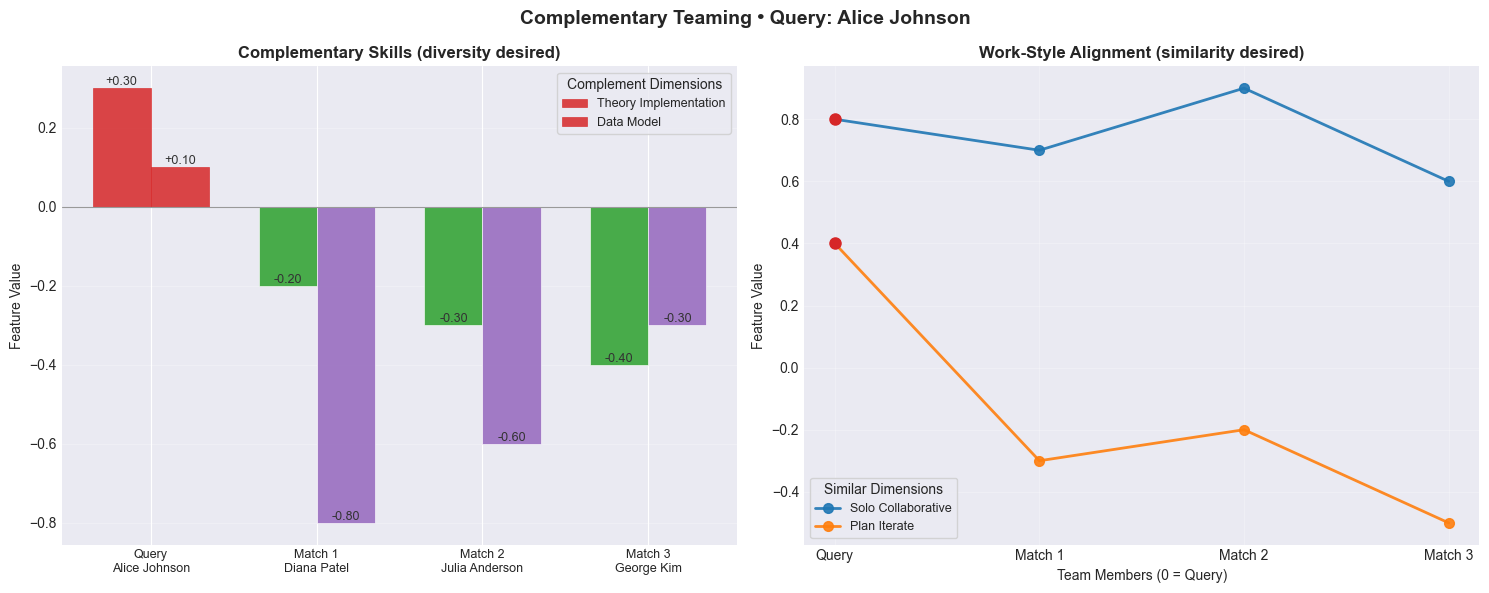

Top matches (lower = better under simple metric):
1. idx= 3  Diana Patel           score=1.407  interest=healthcare
2. idx= 9  Julia Anderson        score=1.418  interest=healthcare
3. idx= 6  George Kim            score=1.597  interest=energy


In [27]:
similar_dims = ['solo_collaborative', 'plan_iterate']        # want similar
complement_dims = ['theory_implementation', 'data_model']    # want diverse

query, top_matches = find_complementary_team(
    students,
    similar_dims=similar_dims,
    complement_dims=complement_dims,
    query_idx=0,     # or None to auto-pick first 'seeking'
    n_matches=3
)

###  **Smart Matching Insights:**
- **Skill diversity**: Team members cover different strengths
- **Work style alignment**: Similar collaboration preferences reduce friction
- **Balanced teams**: Neither too similar (groupthink) nor too different (conflict)
- **Customizable strategy**: Adjust weights based on project needs

# Part 7: k-NN for Different ML Tasks

## Beyond Finding Neighbors: Classification and Regression

### **K-NN Versatility:**
The same algorithm can handle:
- **Classification**: Predict discrete categories (team preference)
- **Regression**: Predict continuous values (collaboration score)
- **Density estimation**: Find outliers or clusters
- **Recommendation**: Suggest similar items

## Classification: Predicting Team Preference

### **Task:** Can we predict if someone prefers solo or team work from their features?


Classification metrics by k (2-fold Stratified CV):


,k,accuracy,precision,recall,is_best_k
0,1,1.000,1.000,1.000,True
1,2,0.800,1.000,0.750,False
2,3,0.800,0.800,1.000,False
3,4,0.800,0.800,1.000,False
4,5,0.800,0.800,1.000,False



Feature importance (accuracy drop when removed) using k=1 (baseline acc=1.000):


,dimension,importance,rank
0,solo_collaborative,0.3000,1
1,research_industry,0.1000,2
2,foundational_applied,0.1000,3
3,theory_implementation,0.0000,4
4,structured_exploratory,0.0000,5
5,depth_breadth,0.0000,6
6,plan_iterate,0.0000,7
7,data_model,0.0000,8


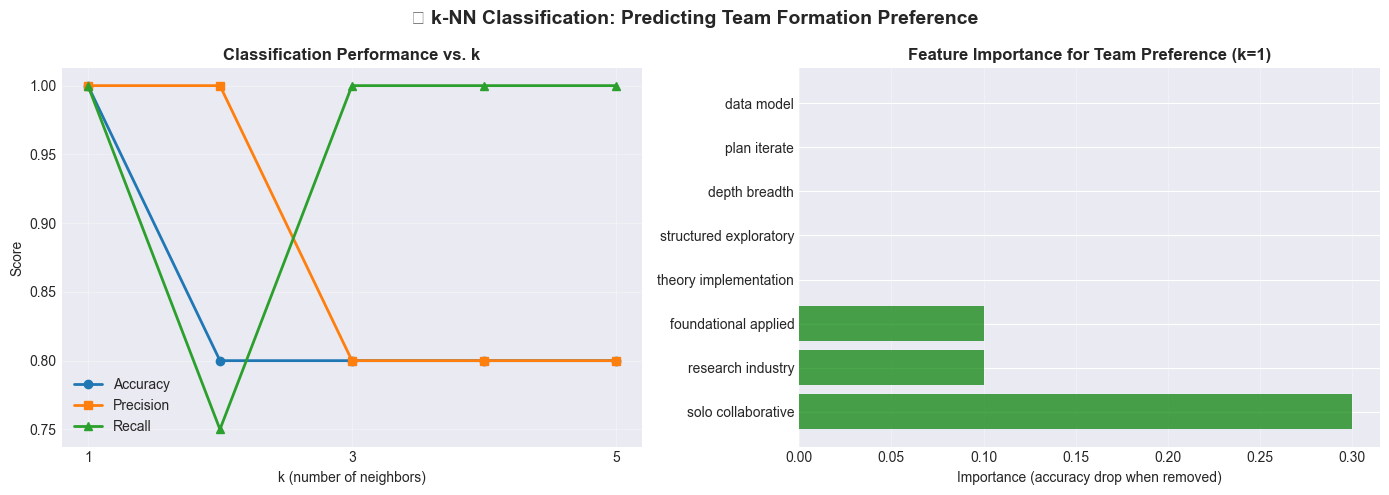

In [31]:
def knn_classification_analysis():
    """
    k-NN classification with 5-fold stratified CV (auto-adjusted for tiny data).
    Prints tables for metrics and LOFO feature importance, and plots both.
    """
    import numpy as np
    import pandas as pd
    from IPython.display import display
    from sklearn.model_selection import StratifiedKFold, cross_val_score
    from sklearn.metrics import make_scorer, precision_score, recall_score
    from sklearn.neighbors import KNeighborsClassifier

    # Prepare data
    X = students[dimensions].values
    y = students['team_status'].apply(lambda x: 1 if 'seeking' in x else 0).values
    n = len(y)

    # Choose stratified CV with safe n_splits (cannot exceed smallest class count)
    counts = pd.Series(y).value_counts()
    min_class = int(counts.min()) if not counts.empty else 1
    n_splits = max(2, min(5, min_class))  # at least 2, at most 5 and <= min_class
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Maximum valid k is min training size across folds
    # For StratifiedKFold, each train size ≈ n * (n_splits - 1) / n_splits
    n_train_min = n - int(np.ceil(n / n_splits))  # conservative bound
    k_values = list(range(1, min(15, n_train_min) + 1))  # avoid NaNs

    accuracies, precision_scores, recall_scores = [], [], []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        acc = cross_val_score(knn, X, y, cv=skf, scoring='accuracy')
        prec = cross_val_score(
            knn, X, y, cv=skf,
            scoring=make_scorer(precision_score, zero_division=0)
        )
        rec = cross_val_score(
            knn, X, y, cv=skf,
            scoring=make_scorer(recall_score, zero_division=0)
        )
        accuracies.append(acc.mean())
        precision_scores.append(prec.mean())
        recall_scores.append(rec.mean())

    # Metrics table
    metrics_df = pd.DataFrame({
        'k': k_values,
        'accuracy': accuracies,
        'precision': precision_scores,
        'recall': recall_scores
    })
    best_k = int(metrics_df.loc[metrics_df['accuracy'].idxmax(), 'k'])
    metrics_df['is_best_k'] = metrics_df['k'] == best_k

    print(f"Classification metrics by k ({n_splits}-fold Stratified CV):")
    display(metrics_df.style.format({'accuracy': '{:.3f}', 'precision': '{:.3f}', 'recall': '{:.3f}'}))

    # LOFO feature importance at best_k
    knn = KNeighborsClassifier(n_neighbors=best_k)
    baseline_acc = metrics_df.loc[metrics_df['k'] == best_k, 'accuracy'].item()

    feature_importance = []
    for i, dim in enumerate(dimensions):
        X_reduced = np.delete(X, i, axis=1)
        scores = cross_val_score(knn, X_reduced, y, cv=skf, scoring='accuracy')
        importance = baseline_acc - scores.mean()
        feature_importance.append({'dimension': dim, 'importance': importance})

    fi_df = (pd.DataFrame(feature_importance)
             .sort_values('importance', ascending=False)
             .reset_index(drop=True))
    fi_df['rank'] = fi_df.index + 1

    print(f"\nFeature importance (accuracy drop when removed) using k={best_k} (baseline acc={baseline_acc:.3f}):")
    display(fi_df.style.format({'importance': '{:.4f}'}))

    # Plots (unchanged logic)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax1 = axes[0]
    ax1.plot(k_values, accuracies, 'o-', label='Accuracy', linewidth=2)
    ax1.plot(k_values, precision_scores, 's-', label='Precision', linewidth=2)
    ax1.plot(k_values, recall_scores, '^-', label='Recall', linewidth=2)
    ax1.set_xlabel('k (number of neighbors)')
    ax1.set_ylabel('Score')
    ax1.set_title('Classification Performance vs. k', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(k_values[::2] if len(k_values) > 1 else k_values)

    ax2 = axes[1]
    order = fi_df['dimension'].tolist()
    values = fi_df['importance'].tolist()
    colors = ['green' if v > 0 else 'red' for v in values]
    ax2.barh(range(len(order)), values, color=colors, alpha=0.7)
    ax2.set_yticks(range(len(order)))
    ax2.set_yticklabels([d.replace('_', ' ') for d in order])
    ax2.set_xlabel('Importance (accuracy drop when removed)')
    ax2.set_title(f'Feature Importance for Team Preference (k={best_k})', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')

    plt.suptitle('📊 k-NN Classification: Predicting Team Formation Preference', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return best_k, accuracies, metrics_df, fi_df

# Run classification analysis
best_k, classification_scores, metrics_table, feature_importance_table = knn_classification_analysis()

### **Classification Insights:**
- **Optimal k**: Balance between over/underfitting (typically 3-7)
- **Feature importance**: Some dimensions strongly predict team preference
- **Performance ceiling**: Natural overlap between solo/team preferences limits accuracy
- **Practical use**: Could suggest team formation to undecided students


# Part 8: Fairness and Ethics in Team Matching

## The Hidden Biases in Our System

###  **Critical Questions:**
- Does our system favor certain groups?
- Are minorities getting fewer quality matches?
- What biases exist in the NLP feature extraction?
- How can we ensure fair team formation?

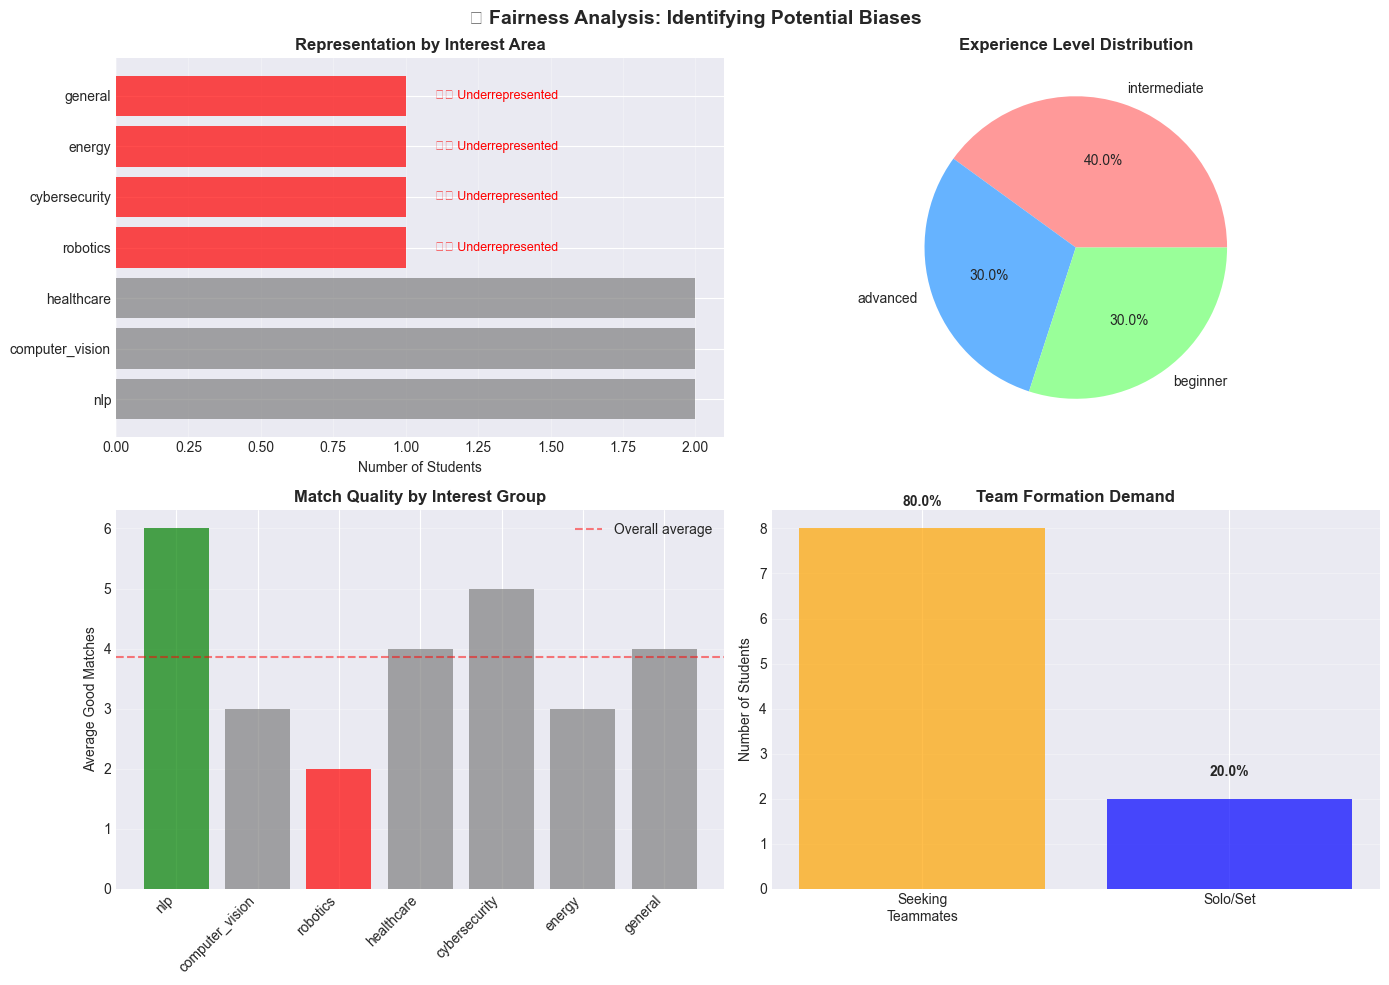

In [33]:
def analyze_matching_fairness():
    """
    Comprehensive fairness analysis of the matching system
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Analysis 1: Representation by interest area
    ax1 = axes[0, 0]
    interest_counts = students['main_interest'].value_counts()
    colors = ['red' if count < 2 else 'green' if count > 3 else 'gray' 
              for count in interest_counts.values]
    
    bars = ax1.barh(range(len(interest_counts)), interest_counts.values, 
                    color=colors, alpha=0.7)
    ax1.set_yticks(range(len(interest_counts)))
    ax1.set_yticklabels(interest_counts.index)
    ax1.set_xlabel('Number of Students')
    ax1.set_title('Representation by Interest Area', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add annotations for underrepresented groups
    for i, (interest, count) in enumerate(interest_counts.items()):
        if count < 2:
            ax1.text(count + 0.1, i, '⚠️ Underrepresented', 
                    va='center', fontsize=9, color='red')
    
    # Analysis 2: Experience level distribution
    ax2 = axes[0, 1]
    exp_counts = students['experience_level'].value_counts()
    ax2.pie(exp_counts.values, labels=exp_counts.index, autopct='%1.1f%%',
           colors=['#ff9999', '#66b3ff', '#99ff99'])
    ax2.set_title('Experience Level Distribution', fontweight='bold')
    
    # Analysis 3: Match quality by group
    ax3 = axes[1, 0]
    
    # Calculate average number of good matches per interest group
    X = students[dimensions].values
    nbrs = NearestNeighbors(n_neighbors=min(10, len(students)-1))
    nbrs.fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Define "good match" as distance < median
    distance_threshold = np.median(distances[:, 1:])
    
    match_quality = {}
    for interest in students['main_interest'].unique():
        mask = students['main_interest'] == interest
        group_indices = np.where(mask)[0]
        
        if len(group_indices) > 0:
            good_matches = []
            for idx in group_indices:
                n_good = np.sum(distances[idx, 1:] < distance_threshold)
                good_matches.append(n_good)
            match_quality[interest] = np.mean(good_matches)
    
    # Plot match quality
    interests = list(match_quality.keys())
    qualities = list(match_quality.values())
    colors = ['red' if q < 3 else 'green' if q > 5 else 'gray' for q in qualities]
    
    bars = ax3.bar(range(len(interests)), qualities, color=colors, alpha=0.7)
    ax3.set_xticks(range(len(interests)))
    ax3.set_xticklabels(interests, rotation=45, ha='right')
    ax3.set_ylabel('Average Good Matches')
    ax3.set_title('Match Quality by Interest Group', fontweight='bold')
    ax3.axhline(y=np.mean(qualities), color='red', linestyle='--', 
               alpha=0.5, label='Overall average')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Analysis 4: Team formation status
    ax4 = axes[1, 1]
    team_status_counts = students['team_status'].value_counts()
    
    # Group into seeking vs not seeking
    seeking = team_status_counts[team_status_counts.index.str.contains('seeking')].sum()
    solo = team_status_counts['solo'] if 'solo' in team_status_counts else 0
    
    ax4.bar(['Seeking\nTeammates', 'Solo/Set'], [seeking, solo], 
           color=['orange', 'blue'], alpha=0.7)
    ax4.set_ylabel('Number of Students')
    ax4.set_title('Team Formation Demand', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels
    total = seeking + solo
    ax4.text(0, seeking + 0.5, f'{seeking/total*100:.1f}%', 
            ha='center', fontweight='bold')
    ax4.text(1, solo + 0.5, f'{solo/total*100:.1f}%', 
            ha='center', fontweight='bold')
    
    plt.suptitle('🔍 Fairness Analysis: Identifying Potential Biases', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return interest_counts, match_quality

# Perform fairness analysis
representation, match_qualities = analyze_matching_fairness()

### **Fairness Findings:**
- **Representation imbalance**: Some interest areas have very few students
- **Match inequality**: Minority groups may have fewer quality matches
- **Supply-demand mismatch**: More students seeking teams than going solo
- **Systematic disadvantage**: Underrepresented groups face matching challenges

## Designing Fair Modifications

###  **Strategies for Fairer Matching:**

In [38]:
class FairTeamMatcher:
    """
    k-NN with fairness constraints for inclusive team formation
    """
    def __init__(self, k=10):
        self.k = k
        
    def find_diverse_team(self, query_student, team_size=4, 
                         diversity_requirements=None):
        """
        Build a team with diversity constraints
        
        Parameters:
        -----------
        query_student : Series
            Student seeking teammates
        team_size : int
            Target team size
        diversity_requirements : dict
            Minimum diversity requirements
            
        Returns:
        --------
        list : Team member indices
        dict : Diversity metrics
        """
        if diversity_requirements is None:
            diversity_requirements = {
                'main_interest': 2,  # At least 2 different interests
                'experience_level': 2  # At least 2 experience levels
            }
        
        # Get candidate pool (k*3 nearest neighbors)
        X = students[dimensions].values
        query_features = query_student[dimensions].values.reshape(1, -1)
        
        nbrs = NearestNeighbors(n_neighbors=min(self.k * 3, len(students)-1))
        nbrs.fit(X)
        distances, indices = nbrs.kneighbors(query_features)
        
        # Initialize team with query student
        team = [query_student.name]
        team_indices = []
        
        # Track diversity
        diversity_tracker = {
            'main_interest': set([query_student['main_interest']]),
            'experience_level': set([query_student['experience_level']])
        }
        
        # Greedy selection with diversity constraints
        for neighbor_idx in indices[0]:
            if len(team) >= team_size:
                break
            
            candidate = students.iloc[neighbor_idx]
            
            # Skip if already in team or not seeking
            if (candidate.name in team or 
                candidate['team_status'] == 'solo'):
                continue
            
            # Check diversity contribution
            adds_interest_diversity = (
                candidate['main_interest'] not in diversity_tracker['main_interest']
                and len(diversity_tracker['main_interest']) < diversity_requirements['main_interest']
            )
            adds_experience_diversity = (
                candidate['experience_level'] not in diversity_tracker['experience_level']
                and len(diversity_tracker['experience_level']) < diversity_requirements['experience_level']
            )
            
            # Prioritize diversity until requirements met
            if adds_interest_diversity or adds_experience_diversity:
                team.append(candidate.name)
                team_indices.append(neighbor_idx)
                diversity_tracker['main_interest'].add(candidate['main_interest'])
                diversity_tracker['experience_level'].add(candidate['experience_level'])
            elif len(diversity_tracker['main_interest']) >= diversity_requirements['main_interest'] and \
                 len(diversity_tracker['experience_level']) >= diversity_requirements['experience_level']:
                # Requirements met, add based on compatibility
                team.append(candidate.name)
                team_indices.append(neighbor_idx)
                diversity_tracker['main_interest'].add(candidate['main_interest'])
                diversity_tracker['experience_level'].add(candidate['experience_level'])
        
        return team, team_indices, diversity_tracker


### Fairness logic overview
We first collect k-NN candidates, then greedily add members that increase diversity in main_interest and experience_level
before filling remaining slots by proximity.

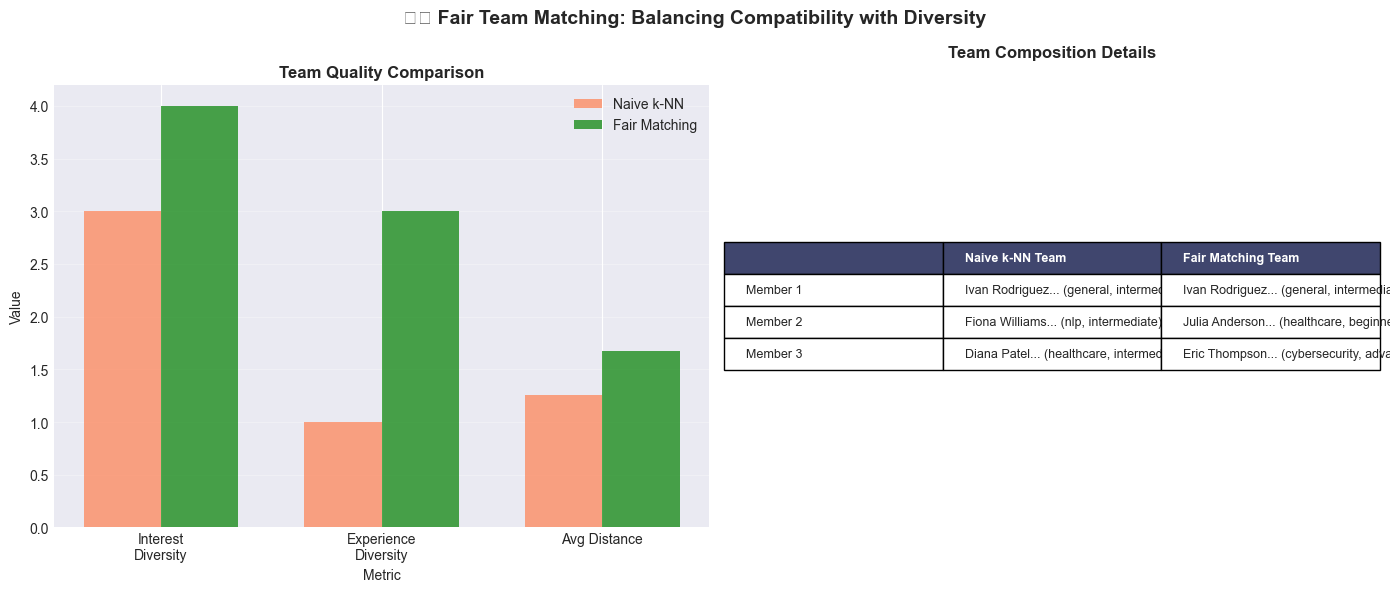

In [41]:

def demonstrate_fair_matching():
    """
    Compare naive k-NN with fair matching
    """
    # Select a student seeking teammates
    query_student = students[students['team_status'].str.contains('seeking')].iloc[0]
    
    # Initialize fair matcher
    fair_matcher = FairTeamMatcher(k=15)
    
    # Get fair team
    fair_team, fair_indices, fair_diversity = fair_matcher.find_diverse_team(
        query_student, 
        team_size=4,
        diversity_requirements={'main_interest': 2, 'experience_level': 2}
    )
    
    # Get naive k-NN team for comparison
    X = students[dimensions].values
    query_features = query_student[dimensions].values.reshape(1, -1)
    
    nbrs = NearestNeighbors(n_neighbors=4)
    nbrs.fit(X)
    distances, naive_indices = nbrs.kneighbors(query_features)
    naive_indices = naive_indices[0][1:]  # Exclude self
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Team composition comparison
    ax1 = axes[0]
    
    # Prepare data for grouped bar chart
    categories = ['Interest\nDiversity', 'Experience\nDiversity', 'Avg Distance']
    
    # Calculate metrics for both teams
    naive_interests = set([query_student['main_interest']])
    naive_experience = set([query_student['experience_level']])
    naive_distances = []
    
    for idx in naive_indices:
        student = students.iloc[idx]
        naive_interests.add(student['main_interest'])
        naive_experience.add(student['experience_level'])
        naive_distances.append(distances[0][list(naive_indices).index(idx)+1])
    
    naive_metrics = [
        len(naive_interests),
        len(naive_experience),
        np.mean(naive_distances)
    ]
    
    fair_distances = []
    for idx in fair_indices:
        dist = np.linalg.norm(
            query_features - students.iloc[idx][dimensions].values
        )
        fair_distances.append(dist)
    
    fair_metrics = [
        len(fair_diversity['main_interest']),
        len(fair_diversity['experience_level']),
        np.mean(fair_distances) if fair_distances else 0
    ]
    
    # Plot grouped bars
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, naive_metrics, width, 
                    label='Naive k-NN', color='coral', alpha=0.7)
    bars2 = ax1.bar(x + width/2, fair_metrics, width, 
                    label='Fair Matching', color='green', alpha=0.7)
    
    ax1.set_xlabel('Metric')
    ax1.set_ylabel('Value')
    ax1.set_title('Team Quality Comparison', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Team member details
    ax2 = axes[1]
    ax2.axis('off')
    
    # Create table comparing teams
    table_data = []
    table_data.append(['', 'Naive k-NN Team', 'Fair Matching Team'])
    
    max_len = max(len(naive_indices), len(fair_indices))
    for i in range(max_len):
        naive_member = ''
        fair_member = ''
        
        if i < len(naive_indices):
            s = students.iloc[naive_indices[i]]
            naive_member = f"{s['name'][:15]}... ({s['main_interest']}, {s['experience_level']})"
        
        if i < len(fair_indices):
            s = students.iloc[fair_indices[i]]
            fair_member = f"{s['name'][:15]}... ({s['main_interest']}, {s['experience_level']})"
        
        table_data.append([f'Member {i+1}', naive_member, fair_member])
    
    # Create table
    table = ax2.table(cellText=table_data, loc='center', cellLoc='left')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header row
    for i in range(3):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax2.set_title('Team Composition Details', fontweight='bold', pad=20)
    
    plt.suptitle('⚖️ Fair Team Matching: Balancing Compatibility with Diversity', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fair_diversity, naive_metrics, fair_metrics

# Demonstrate fair matching
diversity_stats, naive_perf, fair_perf = demonstrate_fair_matching()


## Addressing Algorithmic Bias

### **Bias Mitigation Strategies:**

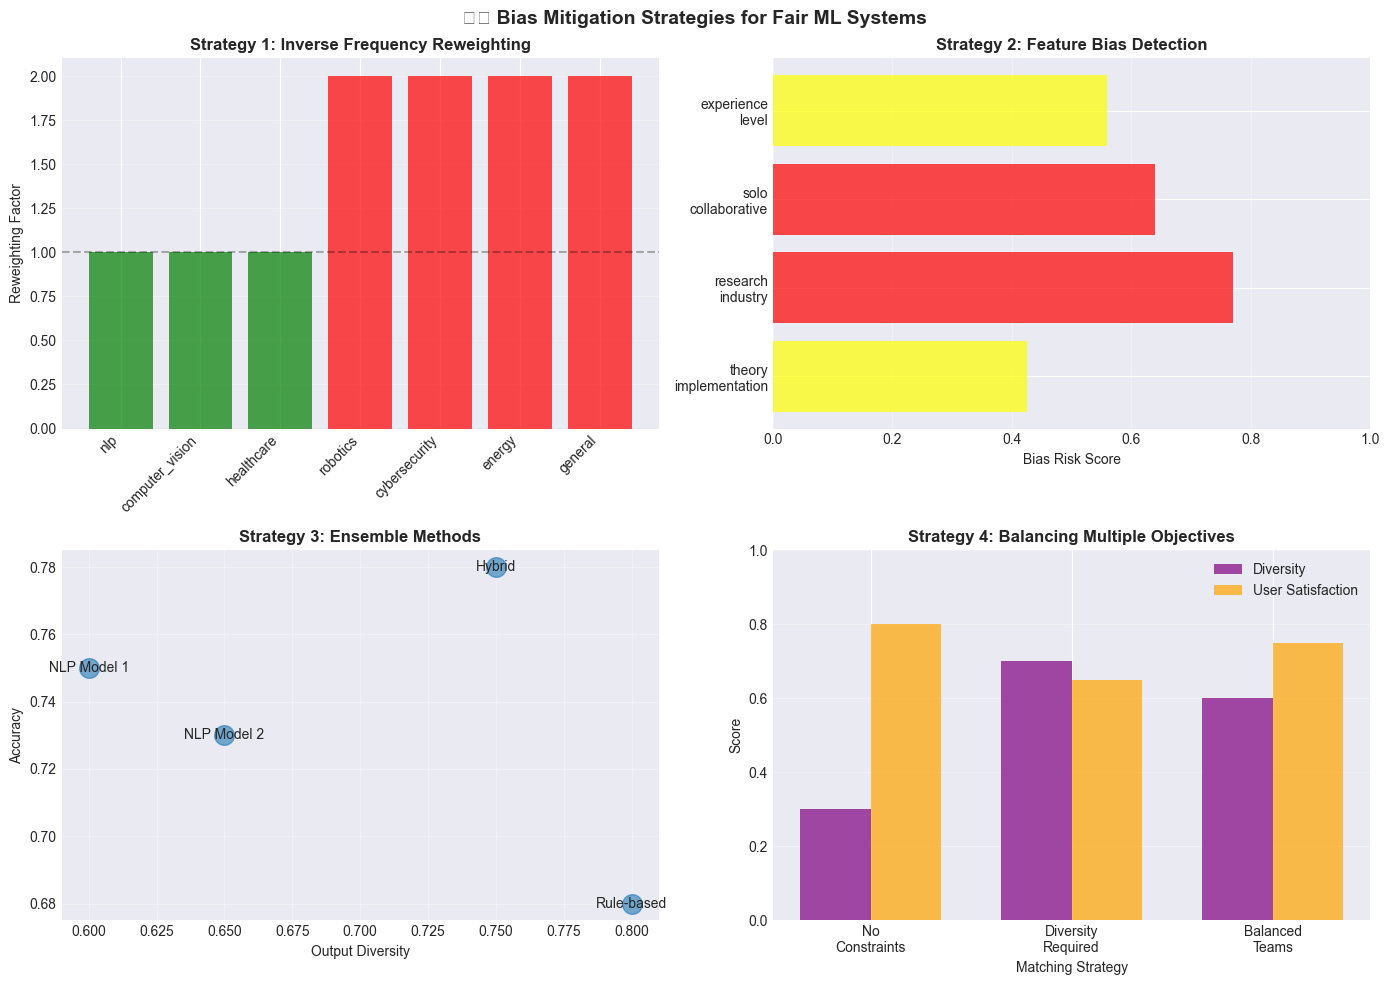

In [42]:
def demonstrate_bias_mitigation():
    """
    Show various strategies to reduce bias in matching
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Strategy 1: Reweighting for balanced representation
    ax1 = axes[0, 0]
    
    # Calculate inverse frequency weights
    interest_counts = students['main_interest'].value_counts()
    max_count = interest_counts.max()
    
    # Create weight for each interest group
    weights = {}
    for interest in interest_counts.index:
        weights[interest] = max_count / interest_counts[interest]
    
    # Visualize weights
    interests = list(weights.keys())
    weight_values = list(weights.values())
    
    bars = ax1.bar(range(len(interests)), weight_values, 
                   color=['red' if w > 1.5 else 'green' if w < 1.2 else 'gray' 
                          for w in weight_values], alpha=0.7)
    
    ax1.set_xticks(range(len(interests)))
    ax1.set_xticklabels(interests, rotation=45, ha='right')
    ax1.set_ylabel('Reweighting Factor')
    ax1.set_title('Strategy 1: Inverse Frequency Reweighting', fontweight='bold')
    ax1.axhline(y=1, color='black', linestyle='--', alpha=0.3)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Strategy 2: Feature debiasing
    ax2 = axes[0, 1]
    
    # Simulate bias detection in features
    potential_biases = {
        'theory_implementation': 'May favor academic writing style',
        'research_industry': 'May favor technical jargon',
        'solo_collaborative': 'May favor extroverted language',
        'experience_level': 'May favor confident tone'
    }
    
    # Create bias risk scores (simulated)
    np.random.seed(42)
    bias_risks = np.random.uniform(0.2, 0.8, 4)
    features = list(potential_biases.keys())[:4]
    
    colors = ['red' if risk > 0.6 else 'yellow' if risk > 0.4 else 'green' 
              for risk in bias_risks]
    
    ax2.barh(range(len(features)), bias_risks, color=colors, alpha=0.7)
    ax2.set_yticks(range(len(features)))
    ax2.set_yticklabels([f.replace('_', '\n') for f in features])
    ax2.set_xlabel('Bias Risk Score')
    ax2.set_title('Strategy 2: Feature Bias Detection', fontweight='bold')
    ax2.set_xlim(0, 1)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Strategy 3: Diverse ensemble
    ax3 = axes[1, 0]
    
    # Simulate multiple models with different biases
    models = ['NLP Model 1', 'NLP Model 2', 'Rule-based', 'Hybrid']
    performance = [0.75, 0.73, 0.68, 0.78]
    diversity = [0.6, 0.65, 0.8, 0.75]
    
    ax3.scatter(diversity, performance, s=200, alpha=0.6)
    for i, model in enumerate(models):
        ax3.annotate(model, (diversity[i], performance[i]), 
                    ha='center', va='center')
    
    ax3.set_xlabel('Output Diversity')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Strategy 3: Ensemble Methods', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Strategy 4: Fairness constraints
    ax4 = axes[1, 1]
    
    # Compare matching with and without constraints
    scenarios = ['No\nConstraints', 'Diversity\nRequired', 'Balanced\nTeams']
    diversity_scores = [0.3, 0.7, 0.6]
    satisfaction_scores = [0.8, 0.65, 0.75]
    
    x = np.arange(len(scenarios))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, diversity_scores, width, 
                    label='Diversity', color='purple', alpha=0.7)
    bars2 = ax4.bar(x + width/2, satisfaction_scores, width, 
                    label='User Satisfaction', color='orange', alpha=0.7)
    
    ax4.set_xlabel('Matching Strategy')
    ax4.set_ylabel('Score')
    ax4.set_title('Strategy 4: Balancing Multiple Objectives', fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(scenarios)
    ax4.legend()
    ax4.set_ylim(0, 1)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('🛡️ Bias Mitigation Strategies for Fair ML Systems', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Demonstrate bias mitigation
demonstrate_bias_mitigation()

### **Mitigation Insights:**
- **Multiple strategies needed**: No single solution eliminates all bias
- **Trade-offs exist**: Fairness may reduce average accuracy
- **Continuous monitoring**: Bias can emerge over time
- **Human oversight essential**: Automated systems need ethical review

# Key Takeaways

## What We've Learned

1. **K-NN is beautifully simple**: No training, just remember and compare
2. **Distance metrics matter**: Different metrics find different neighbors
3. **Curse of dimensionality is real**: More features ≠ better matching
4. **Fairness requires intentional design**: Algorithms can amplify biases
5. **Domain knowledge is crucial**: Generic similarity might not match your needs

## When to Use k-NN

### **Great for:**
- Non-linear patterns
- Local structure varies across space
- Need interpretable predictions
- Small to medium datasets
- When you have good distance metrics

### **Avoid when:**
- Very high dimensions (>50)
- Need fast predictions at scale
- Data has clear global patterns
- Training data is extremely large

Remember: The algorithm is only as good as the features and metrics we choose!

# End of Lecture 2

Thank you for your engaged participation! 🎉

Now go find your dream ML team using what you've learned!